In [1]:
# ===============================
# 1. Import Libraries and Load Data
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Machine Learning Libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional, BatchNormalization, Input, Concatenate, Conv1D, MaxPooling1D, Flatten, Attention
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2

# Hyperparameter Tuning
import keras_tuner as kt
import optuna

# Advanced Boosting Libraries
import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb
import catboost as cb

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Loading and preparing data for Bangkok AQI prediction model...")

# Load historical data
try:
    df = pd.read_csv('BangkokAirQuality.csv')
    print(f"Successfully loaded data with {df.shape[0]} rows and {df.shape[1]} columns")
except FileNotFoundError:
    print("Warning: BangkokAirQuality.csv not found. Using sample data for demonstration.")
    # Create sample data for demonstration if file not found
    # This is just for code testing purposes
    from sklearn.datasets import make_regression
    X, y = make_regression(n_samples=1000, n_features=10, noise=0.1)
    sample_columns = ['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
    df = pd.DataFrame(np.random.randn(1000, len(sample_columns)), columns=sample_columns)
    df['date'] = pd.date_range(start='1/1/2014', periods=1000)


Loading and preparing data for Bangkok AQI prediction model...
Successfully loaded data with 4046 rows and 7 columns


In [2]:
# ===============================
# 2. Data Cleaning and Preprocessing
# ===============================
print("\n--- Starting Data Cleaning and Preprocessing ---")

# Display initial data information
print("\nInitial data information:")
print(f"Shape: {df.shape}")
print("\nData types:")
print(df.dtypes.value_counts())
print("\nMissing values before cleaning:")
missing_before = df.isnull().sum()
print(missing_before[missing_before > 0])

# Convert date column to datetime and sort the data
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')
df = df.sort_values(by='date')
print(f"Converted date column to datetime. Date range: {df['date'].min()} to {df['date'].max()}")

# Add time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['season'] = pd.cut(df['month'], 
                      bins=[0, 3, 6, 9, 12], 
                      labels=['Winter', 'Spring', 'Summer', 'Fall'],
                      include_lowest=True)

# Add cyclical encoding for month and day of week
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year']/365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year']/365)

print("Added time-based features including cyclical encodings")

# Check for outliers in key variables
print("\nChecking for outliers in key pollution variables...")
for col in ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        if not outliers.empty:
            print(f"{col}: {len(outliers)} outliers detected ({len(outliers)/len(df)*100:.2f}%)")
            # Cap outliers instead of removing them
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
            print(f" Outliers capped at [{lower_bound:.2f}, {upper_bound:.2f}]")

# Handle missing values with advanced techniques
print("\nHandling missing values...")

# For pm10: forward fill, backward fill then average
if 'pm10' in df.columns and df['pm10'].isnull().sum() > 0:
    forward_filled = df['pm10'].ffill()
    backward_filled = df['pm10'].bfill()
    average_filled = (forward_filled + backward_filled) / 2
    df['pm10'] = df['pm10'].where(df['pm10'].notna(), average_filled)

# For o3: similar approach
if 'o3' in df.columns and df['o3'].isnull().sum() > 0:
    forward_filled = df['o3'].ffill()
    backward_filled = df['o3'].bfill()
    average_filled = (forward_filled + backward_filled) / 2
    df['o3'] = df['o3'].where(df['o3'].notna(), average_filled)

# For no2 use linear interpolation
if 'no2' in df.columns and df['no2'].isnull().sum() > 0:
    df['no2'] = df['no2'].interpolate(method='linear')


if 'so2' in df.columns and df['so2'].isnull().sum() > 0:
    df['so2'] = df['so2'].interpolate(method='linear')
    print(f"Filled {missing_before['so2']} missing so2 values using linear interpolation")

# Drop column 'co' if more than half of its values are missing
if 'co' in df.columns and df['co'].isnull().sum() > len(df) / 2:
    df = df.drop(columns=['co'])
    print("Dropped 'co' column due to excessive missing values")
elif 'co' in df.columns and df['co'].isnull().sum() > 0:
    df['co'] = df['co'].interpolate(method='linear')
    print(f"Filled {missing_before['co']} missing co values using linear interpolation")

# Fill missing pm25 using linear regression on pm10, o3, and no2
if 'pm25' in df.columns and df['pm25'].isnull().sum() > 0:
    print(f"Filling {df['pm25'].isnull().sum()} missing pm25 values using regression model...")
    train_data_pm25 = df[df['pm25'].notna()]
    X_train_pm25 = train_data_pm25[['pm10', 'o3', 'no2']]
    y_train_pm25 = train_data_pm25['pm25']

    lr_model = LinearRegression()
    lr_model.fit(X_train_pm25, y_train_pm25)
    print(f"PM2.5 regression model R² score: {lr_model.score(X_train_pm25, y_train_pm25):.4f}")

    missing_data_pm25 = df[df['pm25'].isna()]
    if not missing_data_pm25.empty:
        X_missing = missing_data_pm25[['pm10', 'o3', 'no2']]
        # Check for NaN values in X_missing and handle them
        X_missing_filled = X_missing.fillna(X_missing.mean())  # Fill any remaining NaNs with mean values
        predicted_values = lr_model.predict(X_missing_filled)
        df.loc[df['pm25'].isna(), 'pm25'] = predicted_values

# Filter data to a specific date range (if needed)
start_date = '2014-01-01'
end_date = '2025-02-03'
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
print(f"Filtered data to range: {start_date} to {end_date}")

# Calculate Final AQI as the Maximum of Pollutants
print("\nCalculating AQI based on maximum pollutant values...")
df['AQI'] = df[['pm25', 'pm10', 'o3', 'no2', 'so2']].max(axis=1)
print(f"AQI range: {df['AQI'].min():.2f} to {df['AQI'].max():.2f}")

# Check for any remaining missing values
missing_after = df.isnull().sum()
print("\nMissing values after cleaning:")
print(missing_after[missing_after > 0])

# Create lag features for predictors (simulate forecasting using previous day's data)
print("\nCreating lag features for time series forecasting...")
lag_columns = ['pm25', 'pm10', 'o3', 'no2', 'so2']
if 'co' in df.columns:
    lag_columns.append('co')

# Create multiple lag features (1-day, 3-day, 7-day)
for col in lag_columns:
    df[f'{col}_lag1'] = df[col].shift(1)
    df[f'{col}_lag3'] = df[col].shift(3)
    df[f'{col}_lag7'] = df[col].shift(7)

# Create rolling mean features for key variables
for col in ['pm25', 'pm10', 'o3', 'no2', 'so2']:
    df[f'{col}_rolling3'] = df[col].rolling(window=3).mean().shift(1)
    df[f'{col}_rolling7'] = df[col].rolling(window=7).mean().shift(1)
    df[f'{col}_rolling14'] = df[col].rolling(window=14).mean().shift(1)
    df[f'{col}_rolling30'] = df[col].rolling(window=30).mean().shift(1)

# Create rolling standard deviation features (volatility)
for col in ['pm25', 'pm10', 'o3', 'no2', 'so2']:
    df[f'{col}_std7'] = df[col].rolling(window=7).std().shift(1)
    df[f'{col}_std30'] = df[col].rolling(window=30).std().shift(1)

# Create target variable (next day's AQI)
df['next_day_AQI'] = df['AQI'].shift(-1)

# Create interaction terms between key variables
df['pm25_pm10_ratio'] = df['pm25'] / df['pm10'].replace(0, np.nan)
df['pm25_pm10_ratio'] = df['pm25_pm10_ratio'].fillna(df['pm25_pm10_ratio'].mean())

# Drop rows with NaN values after creating lag features
df_with_lags = df.copy()
df = df.dropna().reset_index(drop=True)
print(f"Created lag features, rolling statistics, and interaction terms. Final dataset shape: {df.shape}")



--- Starting Data Cleaning and Preprocessing ---

Initial data information:
Shape: (4046, 7)

Data types:
float64    6
object     1
Name: count, dtype: int64

Missing values before cleaning:
pm25     945
pm10      15
o3        47
no2      205
so2     1798
co      3083
dtype: int64
Converted date column to datetime. Date range: 2013-12-31 00:00:00 to 2025-02-04 00:00:00
Added time-based features including cyclical encodings

Checking for outliers in key pollution variables...
pm25: 72 outliers detected (1.78%)
 Outliers capped at [-1.00, 159.00]
pm10: 51 outliers detected (1.26%)
 Outliers capped at [-10.00, 86.00]
o3: 164 outliers detected (4.05%)
 Outliers capped at [-9.50, 42.50]
no2: 114 outliers detected (2.82%)
 Outliers capped at [-9.00, 31.00]
so2: 150 outliers detected (3.71%)
 Outliers capped at [-3.50, 8.50]
co: 33 outliers detected (0.82%)
 Outliers capped at [1.00, 17.00]

Handling missing values...
Filled 1798 missing so2 values using linear interpolation
Dropped 'co' col

In [3]:
# ===============================
# 3. Exploratory Data Analysis (EDA)
# ===============================
print("\n--- Starting Exploratory Data Analysis ---")

# Create a directory for saving EDA plots
import os
os.makedirs('eda_plots', exist_ok=True)

# 3.1 Basic statistics of the dataset
print("\nBasic statistics of key variables:")
stats_df = df[['AQI', 'pm25', 'pm10', 'o3', 'no2', 'so2']].describe()
if 'co' in df.columns:
    stats_df = pd.concat([stats_df, df[['co']].describe()], axis=1)
print(stats_df)



--- Starting Exploratory Data Analysis ---

Basic statistics of key variables:
               AQI         pm25         pm10           o3          no2  \
count  4013.000000  4013.000000  4013.000000  4013.000000  4013.000000   
mean     81.850089    81.819688    38.398580    17.500872    11.202342   
std      28.910695    28.923365    16.104974     9.635908     7.601509   
min      11.000000    11.000000     4.000000     1.000000     1.000000   
25%      60.000000    60.000000    26.000000    10.000000     5.000000   
50%      75.398612    75.113805    35.000000    16.000000    10.000000   
75%      98.000000    98.000000    49.000000    23.000000    16.000000   
max     159.000000   159.000000    86.000000    42.500000    31.000000   

               so2  
count  4013.000000  
mean      2.616372  
std       2.337166  
min       1.000000  
25%       1.000000  
50%       1.000000  
75%       3.500000  
max       8.500000  


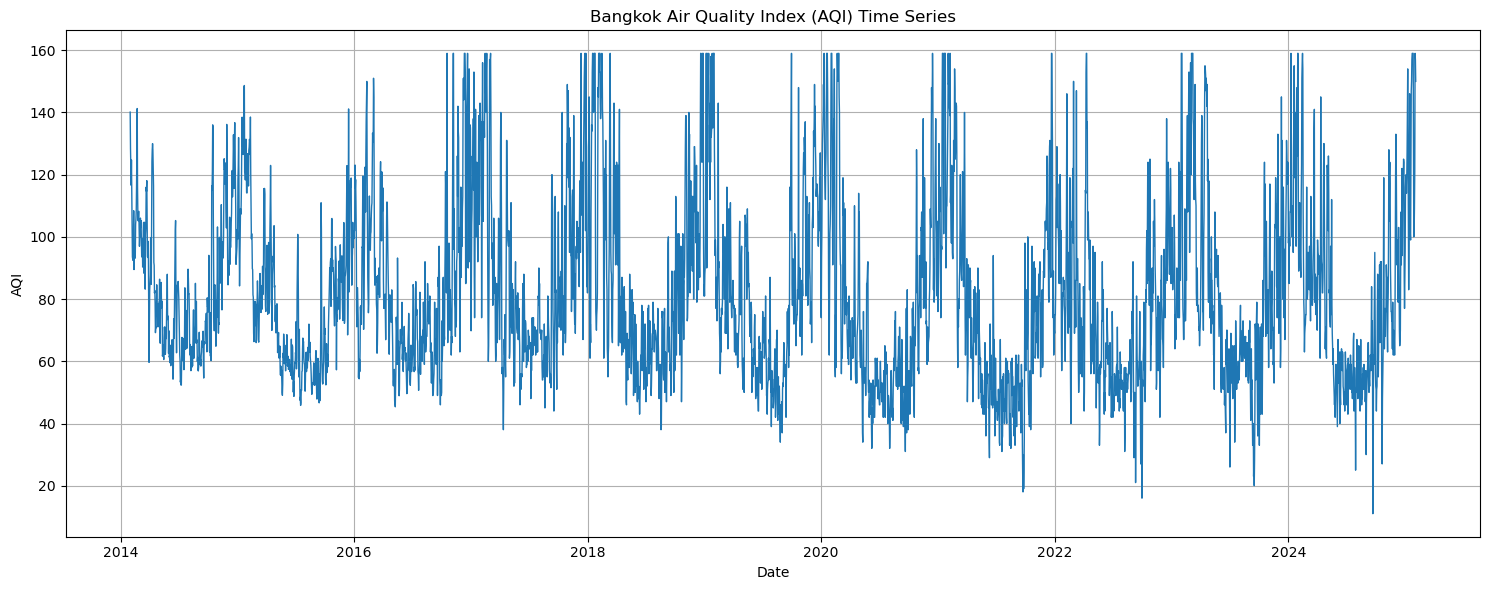

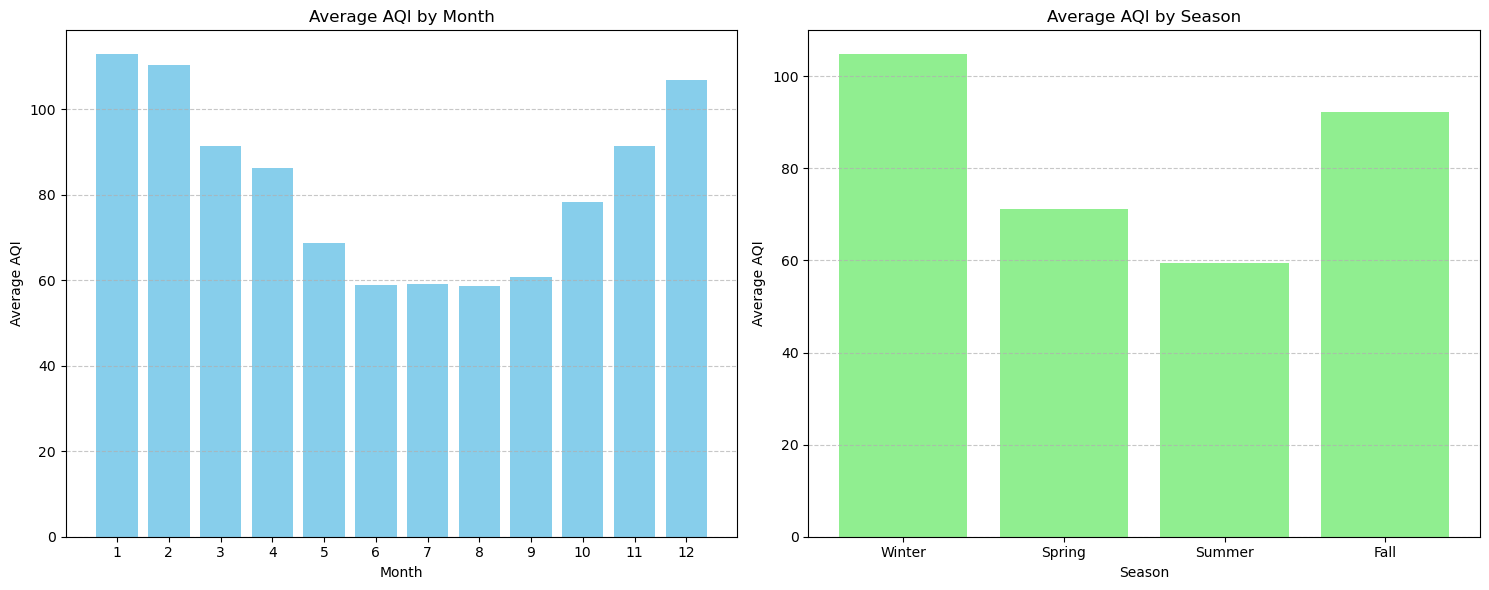

In [4]:
# 3.2 Time series analysis of AQI
plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['AQI'], linewidth=1)
plt.title('Bangkok Air Quality Index (AQI) Time Series')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.grid(True)
plt.tight_layout()
plt.savefig('eda_plots/aqi_time_series.png')

# 3.3 Monthly and seasonal patterns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Monthly patterns
monthly_aqi = df.groupby(df['date'].dt.month)['AQI'].mean()
ax1.bar(monthly_aqi.index, monthly_aqi.values, color='skyblue')
ax1.set_title('Average AQI by Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average AQI')
ax1.set_xticks(range(1, 13))
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Seasonal patterns
seasonal_aqi = df.groupby('season')['AQI'].mean()
ax2.bar(seasonal_aqi.index, seasonal_aqi.values, color='lightgreen')
ax2.set_title('Average AQI by Season')
ax2.set_xlabel('Season')
ax2.set_ylabel('Average AQI')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('eda_plots/aqi_seasonal_patterns.png')


Features most correlated with AQI:
AQI              1.000000
pm25             0.999739
pm10_lag1        0.897688
next_day_AQI     0.876512
pm25_lag1        0.876090
                   ...   
so2_rolling14   -0.071295
so2_rolling30   -0.080891
so2_std30       -0.089853
day_of_year     -0.195544
month           -0.198677
Name: AQI, Length: 64, dtype: float64


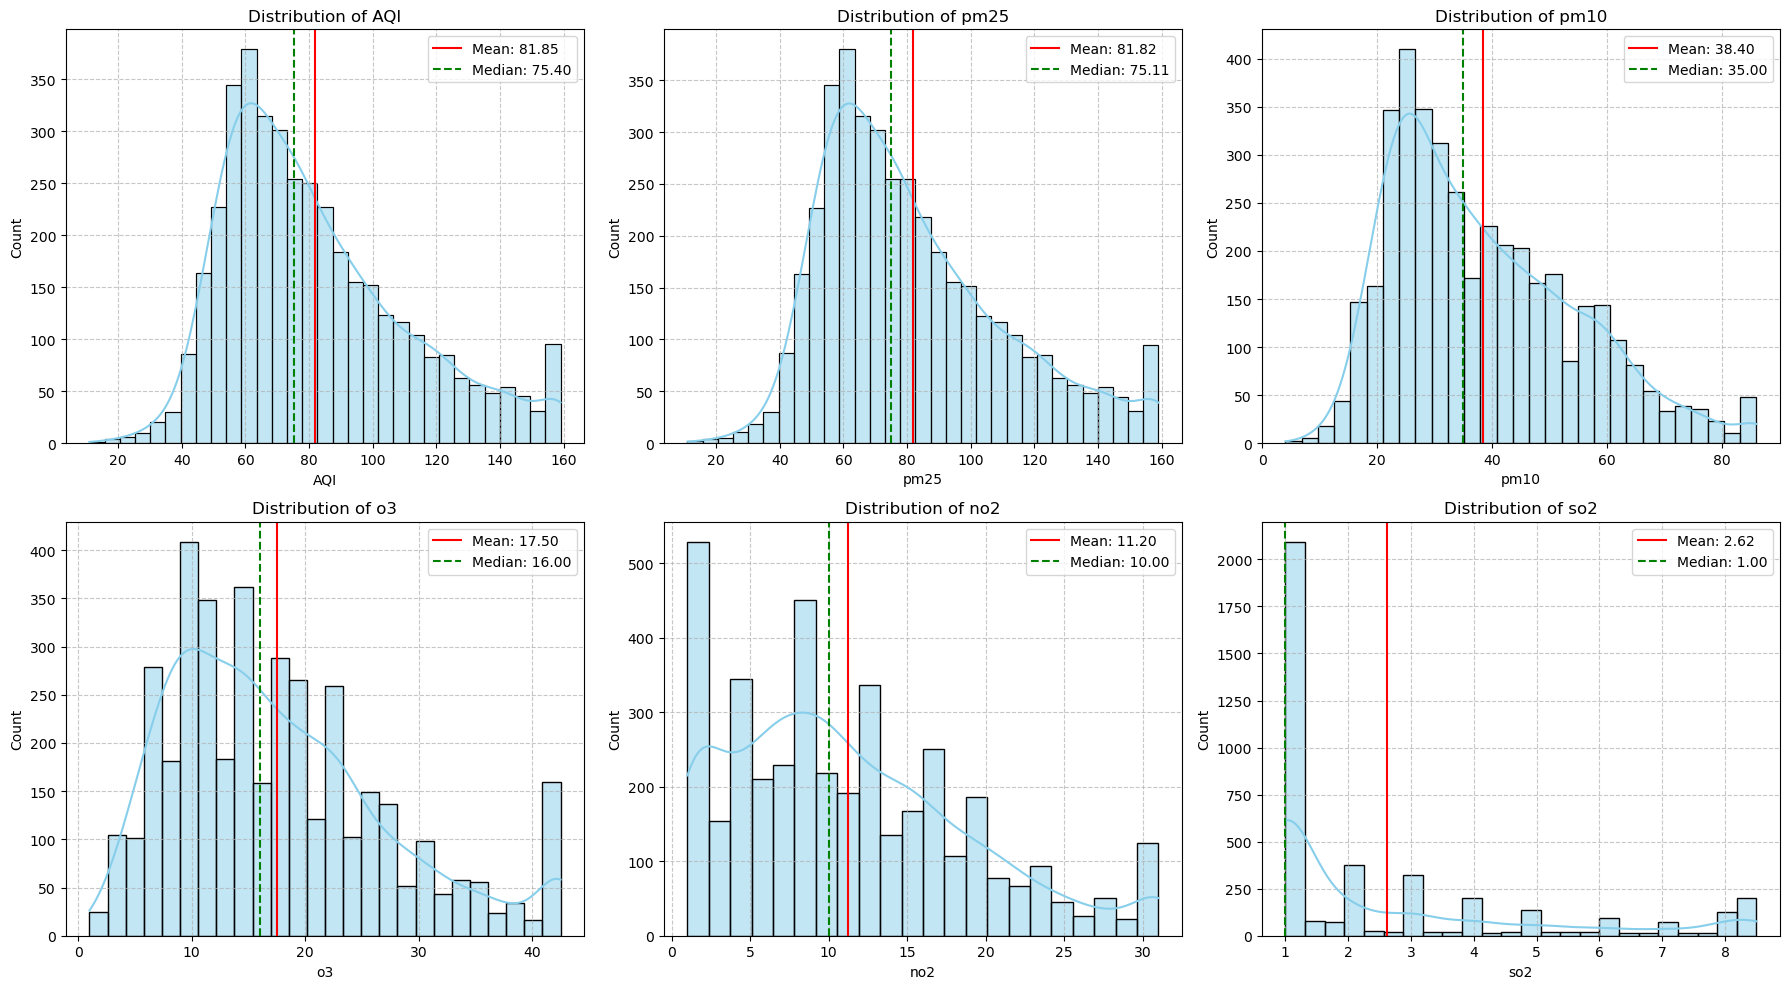

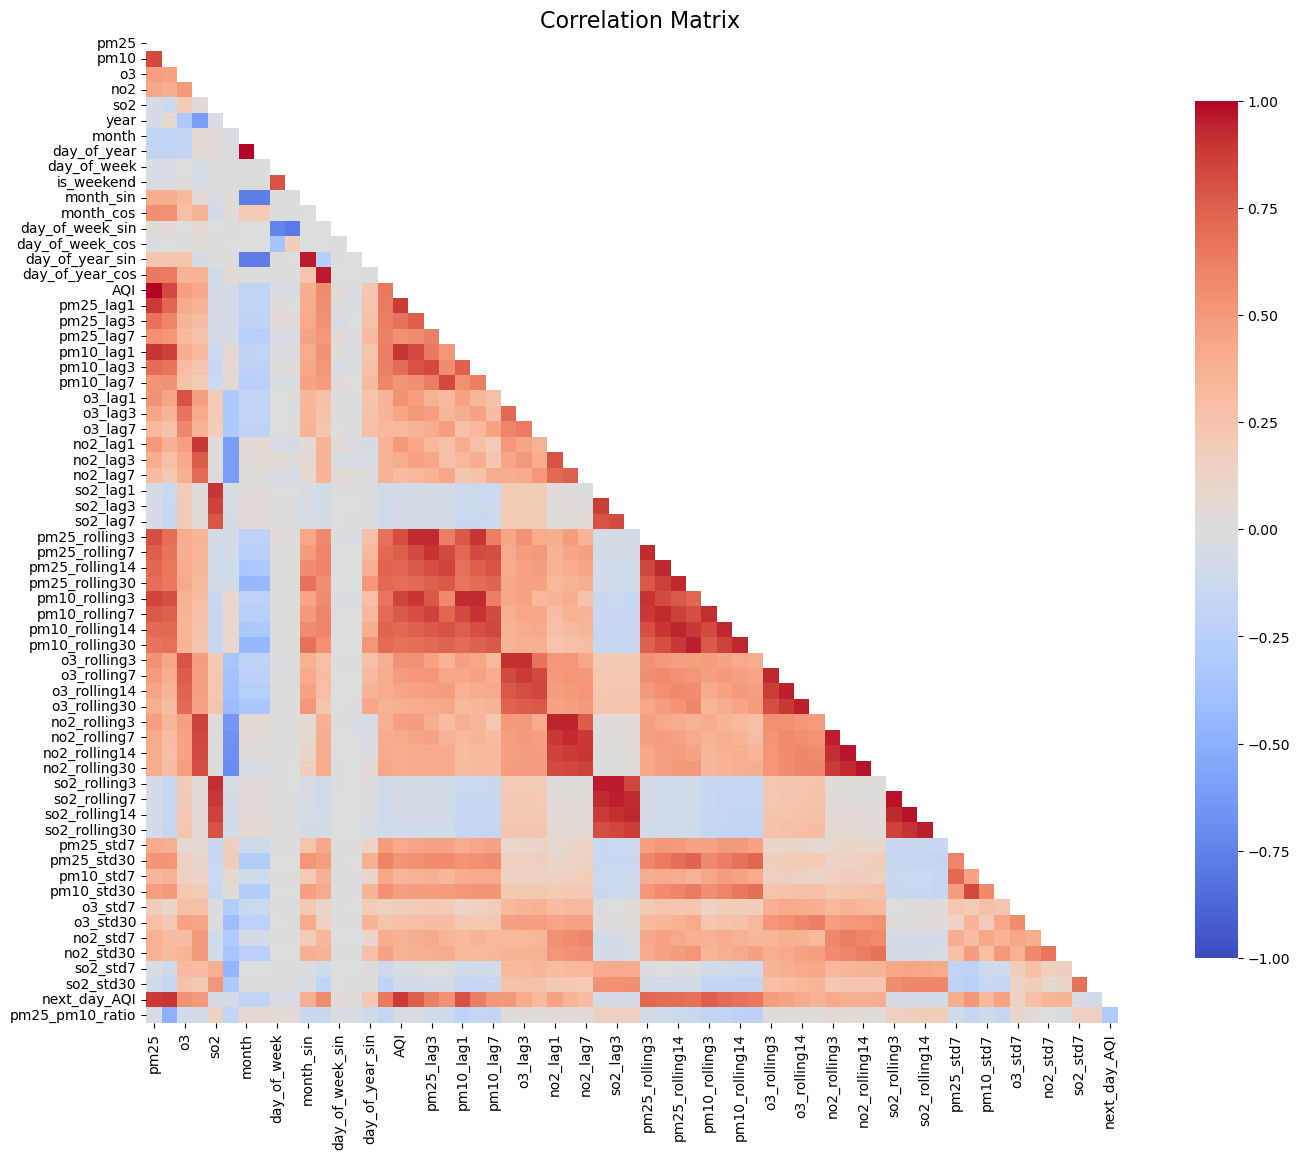

In [5]:
# 3.4 Distribution of AQI and key pollutants
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(['AQI', 'pm25', 'pm10', 'o3', 'no2', 'so2']):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Add mean and median lines
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[i].axvline(mean_val, color='red', linestyle='-', label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
    axes[i].legend()

plt.tight_layout()
plt.savefig('eda_plots/pollutant_distributions.png')

# 3.5 Correlation analysis with heatmap
# Calculate correlation matrix
correlation_matrix = df.select_dtypes(include=[np.number]).corr()

# Sort correlations with AQI
aqi_correlations = correlation_matrix['AQI'].sort_values(ascending=False)
print("\nFeatures most correlated with AQI:")
print(aqi_correlations)

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=False, 
            cmap='coolwarm',
            vmin=-1, vmax=1,
            square=True, 
            cbar_kws={"shrink": .8})

plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.savefig('eda_plots/correlation_heatmap.png')

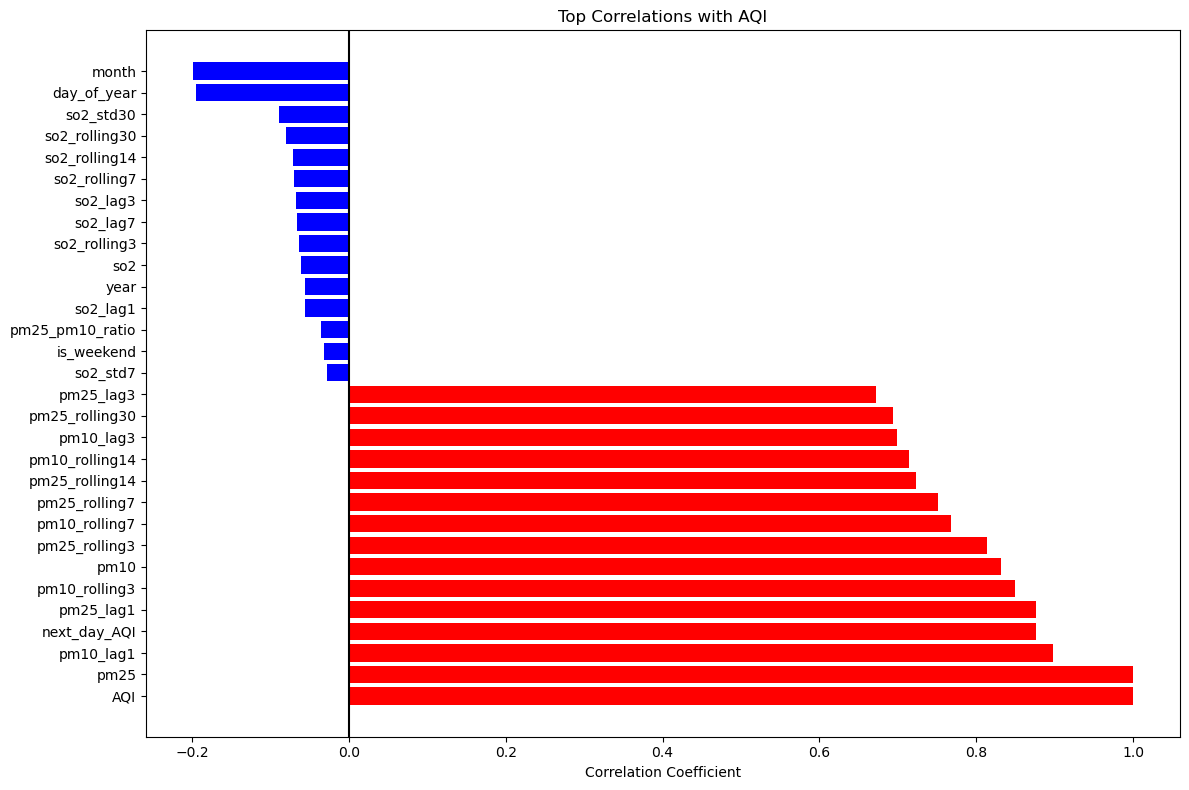

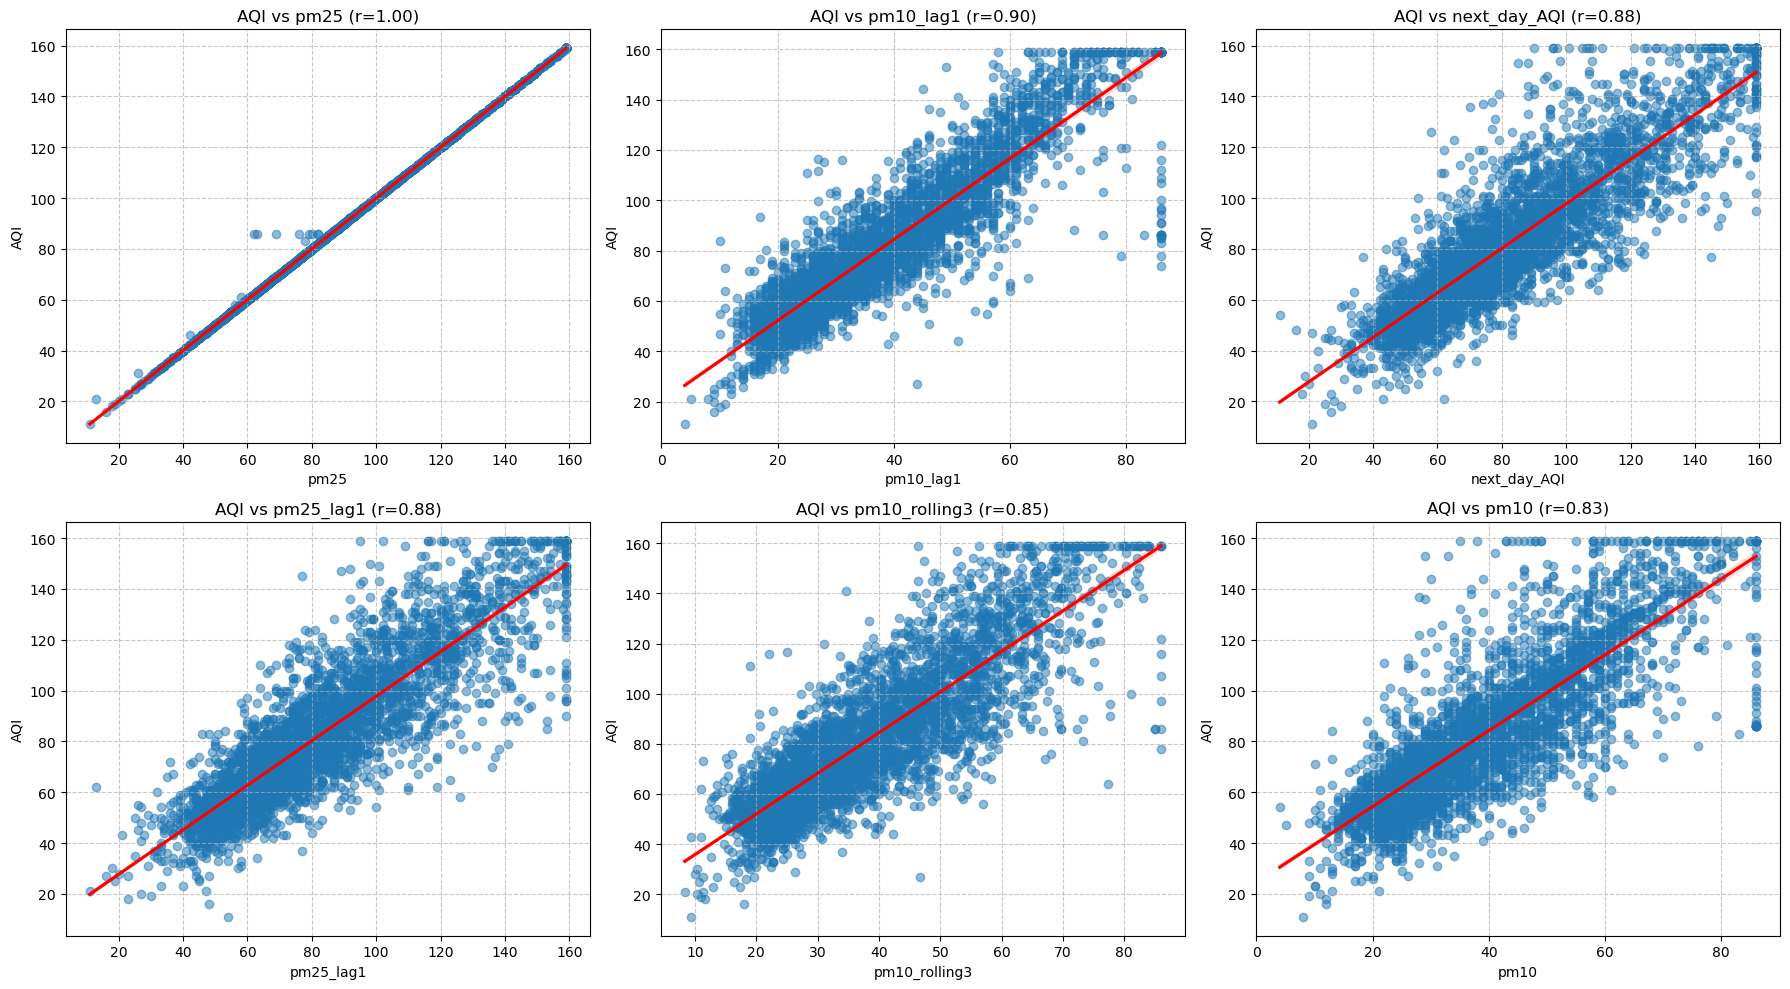

In [6]:
# 3.6 Top correlations with AQI
plt.figure(figsize=(12, 8))
top_correlations = aqi_correlations[:15]  # Top 15 positive correlations
bottom_correlations = aqi_correlations[-15:]  # Top 15 negative correlations
all_top_correlations = pd.concat([top_correlations, bottom_correlations])

# Plot horizontal bar chart
bars = plt.barh(all_top_correlations.index, all_top_correlations.values, color=['red' if x > 0 else 'blue' for x in all_top_correlations.values])
plt.axvline(x=0, color='black', linestyle='-')
plt.title('Top Correlations with AQI')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.savefig('eda_plots/top_aqi_correlations.png')

# 3.7 Scatter plots of AQI vs top correlated features
top_features = aqi_correlations[1:7].index.tolist()  # Skip AQI itself
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    sns.regplot(x=df[feature], y=df['AQI'], ax=axes[i], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    axes[i].set_title(f'AQI vs {feature} (r={correlation_matrix.loc["AQI", feature]:.2f})')
    axes[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('eda_plots/aqi_scatter_plots.png')


Augmented Dickey-Fuller Test for AQI:
ADF Statistic: -5.1699
p-value: 0.0000
Critical Values: {'1%': -3.4319850573119437, '5%': -2.8622624788783146, '10%': -2.567154583183171}
Result: The series is stationary (reject H0)


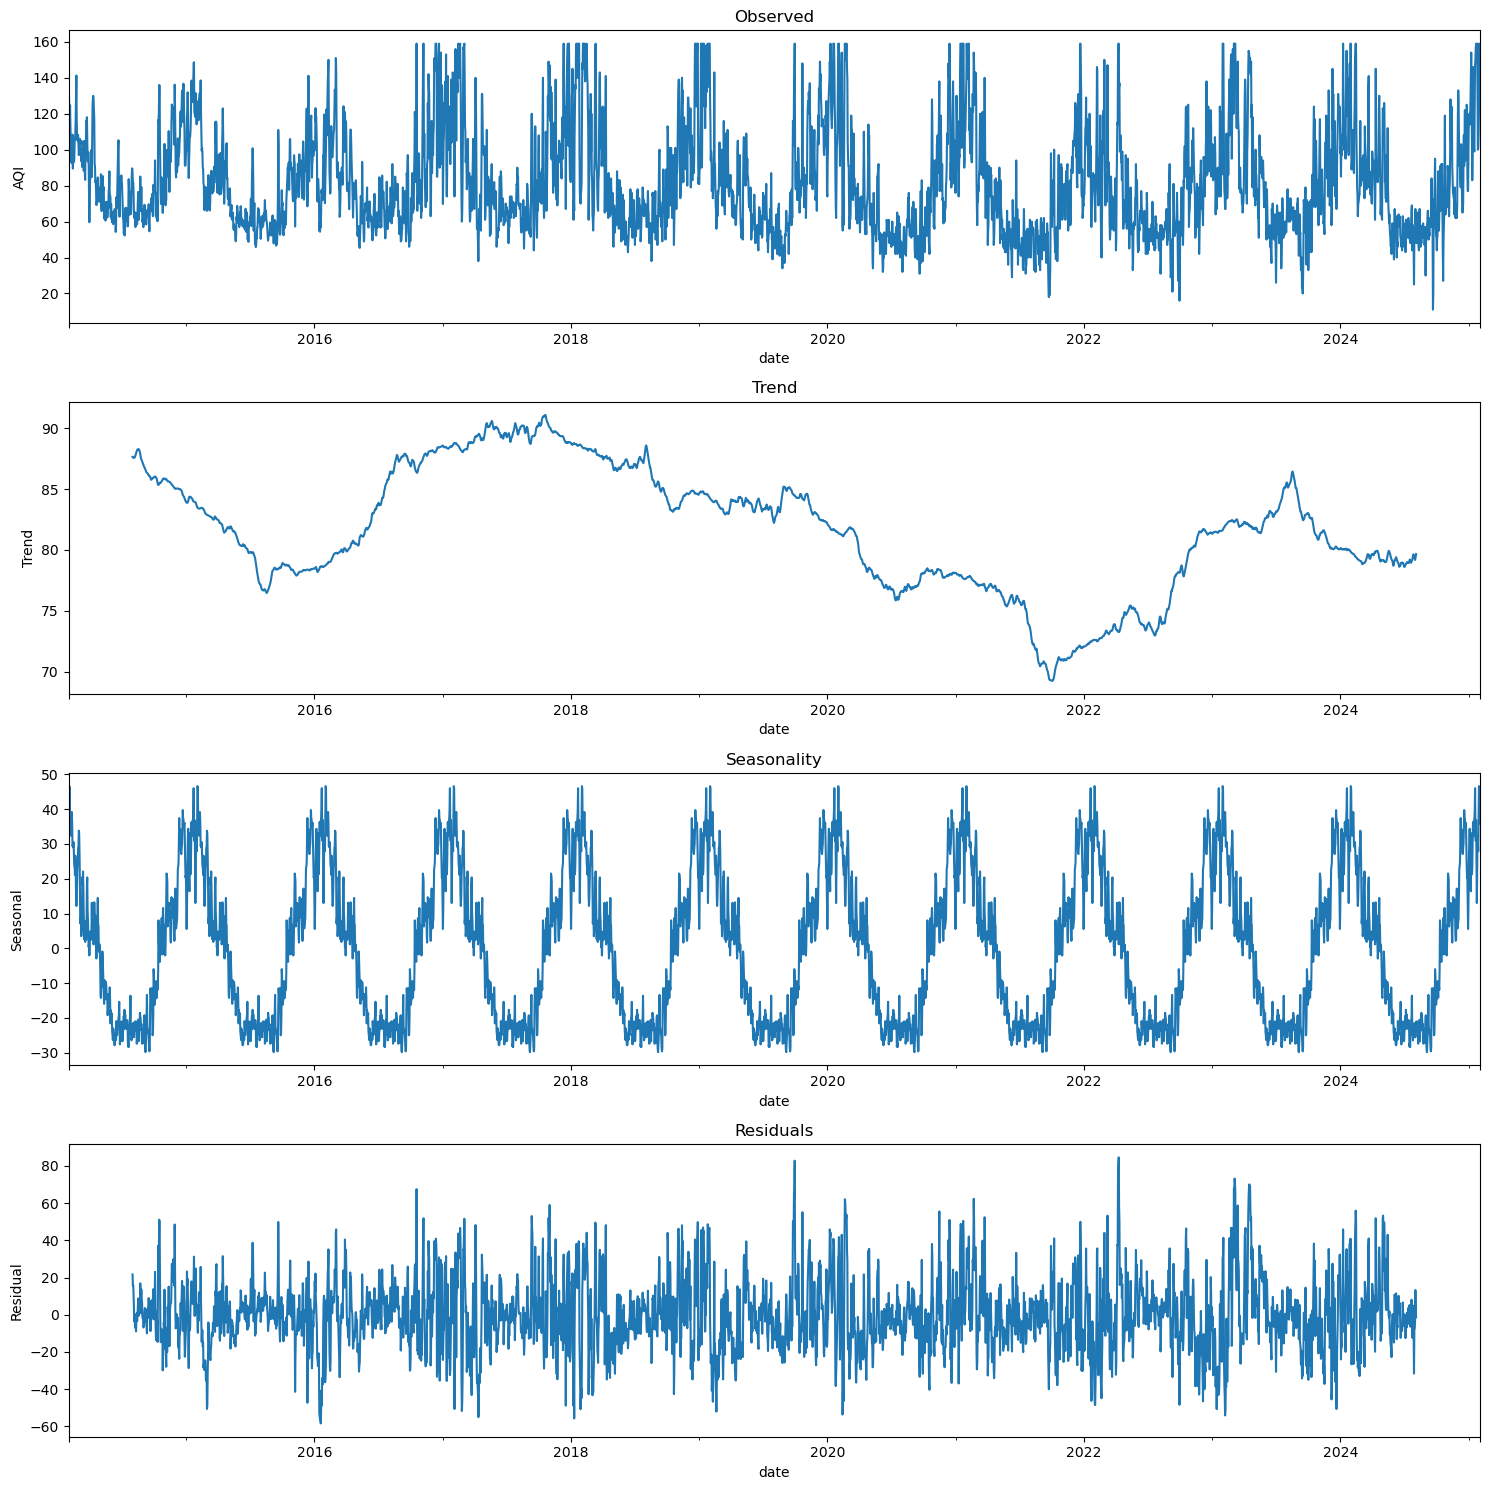

In [7]:
# 3.8 Time series decomposition
if len(df) > 365:  # Need sufficient data for decomposition
    # Resample to daily data if there are multiple entries per day
    aqi_ts = df.set_index('date')['AQI'].resample('D').mean()
    
    # Fill any missing values in the resampled series
    aqi_ts = aqi_ts.fillna(method='ffill')
    
    # Perform time series decomposition
    decomposition = seasonal_decompose(aqi_ts, model='additive', period=365)
    
    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 15))
    
    decomposition.observed.plot(ax=ax1)
    ax1.set_title('Observed')
    ax1.set_ylabel('AQI')
    
    decomposition.trend.plot(ax=ax2)
    ax2.set_title('Trend')
    ax2.set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonality')
    ax3.set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=ax4)
    ax4.set_title('Residuals')
    ax4.set_ylabel('Residual')
    
    plt.tight_layout()
    plt.savefig('eda_plots/aqi_decomposition.png')
    
    # Perform Augmented Dickey-Fuller test to check stationarity
    result = adfuller(aqi_ts.dropna())
    print('\nAugmented Dickey-Fuller Test for AQI:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values: {result[4]}')
    if result[1] <= 0.05:
        print("Result: The series is stationary (reject H0)")
    else:
        print("Result: The series is non-stationary (fail to reject H0)")

# 3.9 Weather conditions impact on AQI
if any(col.startswith('conditions_') for col in df.columns):
    condition_cols = [col for col in df.columns if col.startswith('conditions_')]
    
    # Create a new column with the actual condition name
    df['weather_condition'] = ''
    for col in condition_cols:
        condition_name = col.replace('conditions_', '')
        df.loc[df[col] == 1, 'weather_condition'] = condition_name
    
    # Plot AQI by weather condition
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='weather_condition', y='AQI', data=df)
    plt.title('AQI Distribution by Weather Condition')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('eda_plots/aqi_by_weather.png')


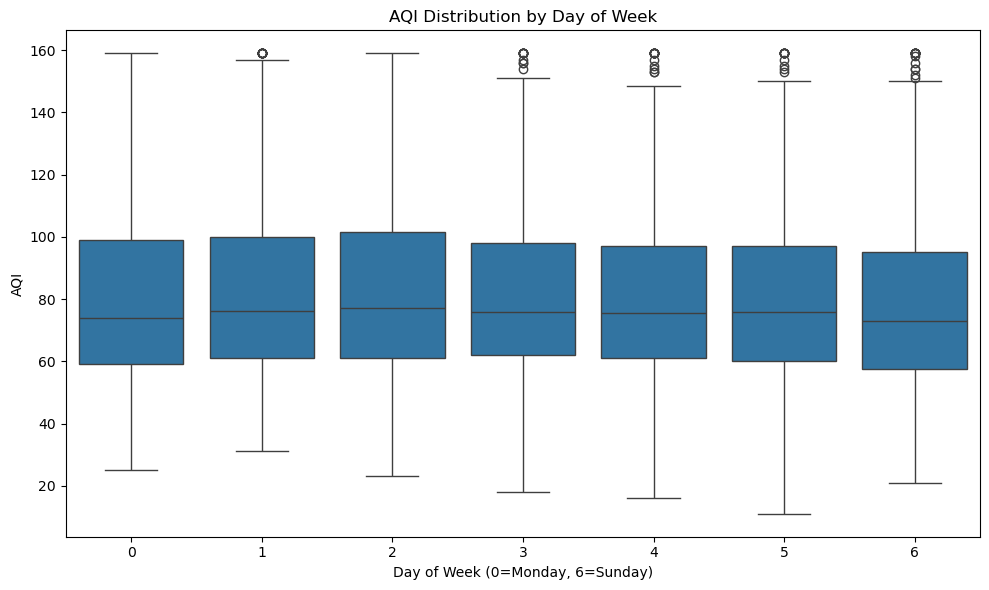

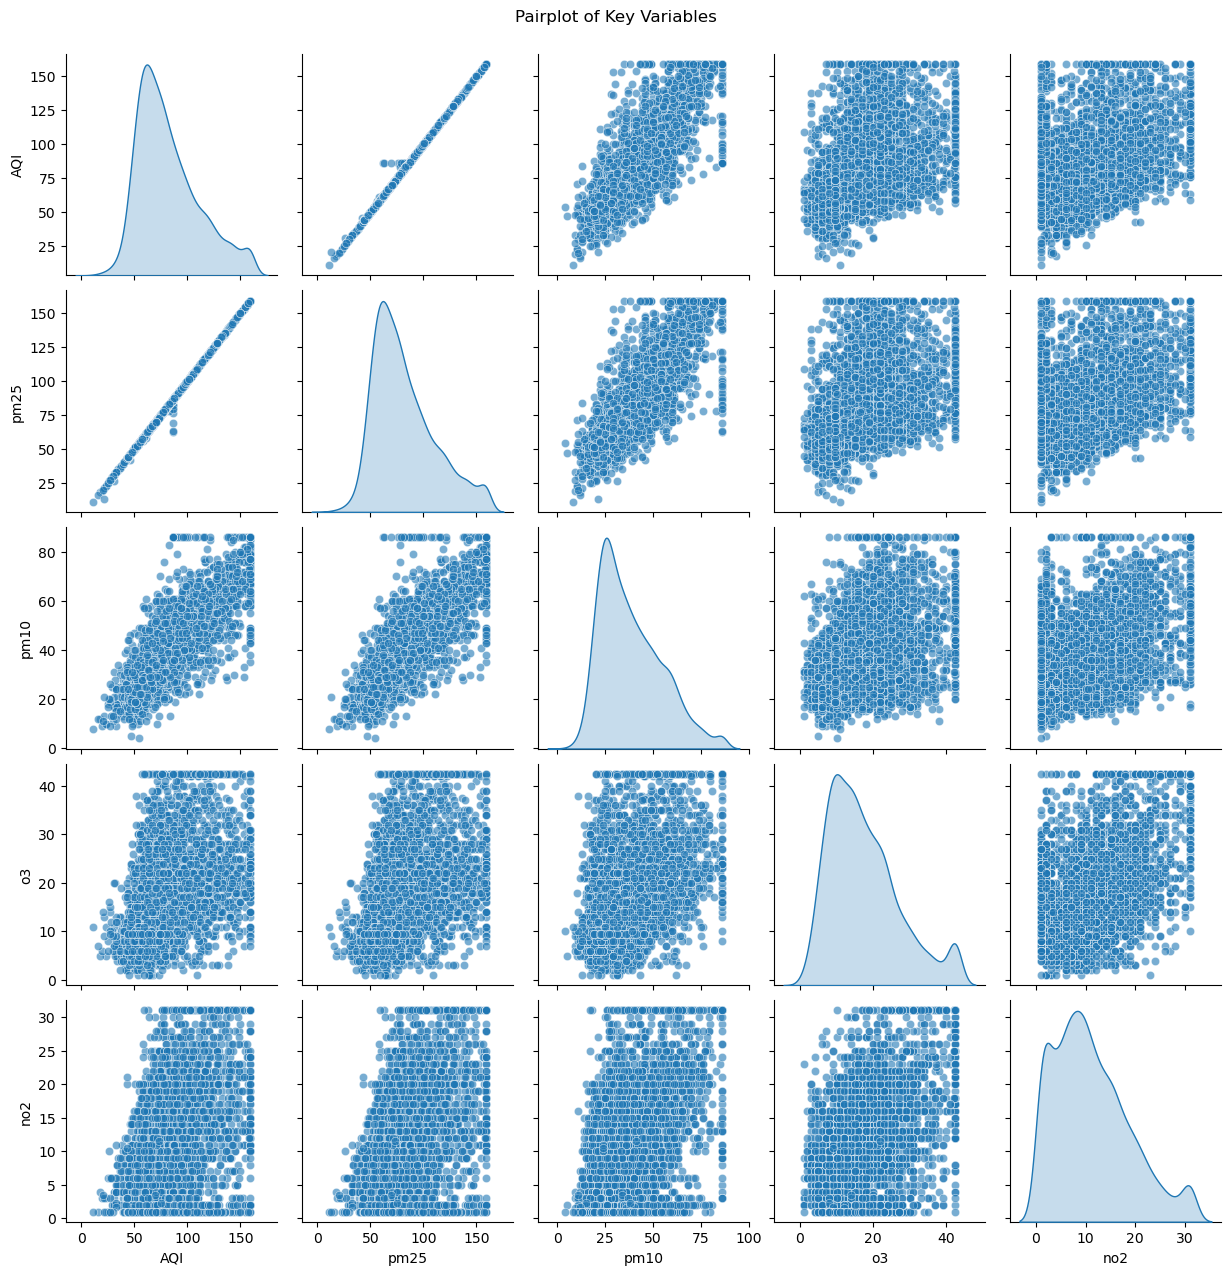

In [8]:
# 3.10 Weekday vs Weekend AQI patterns
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='AQI', data=df)
plt.title('AQI Distribution by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.tight_layout()
plt.savefig('eda_plots/aqi_by_day.png')

# 3.11 Pairplot of key variables
key_vars = ['AQI', 'pm25', 'pm10', 'o3', 'no2']
sns.pairplot(df[key_vars], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Key Variables', y=1.02)
plt.savefig('eda_plots/key_vars_pairplot.png')


Top 15 features by importance:
  Feature  Importance
0    pm25    0.999505
1    pm10    0.000479
4     so2    0.000007
2      o3    0.000006
3     no2    0.000003

EDA completed. Plots saved to 'eda_plots' directory.


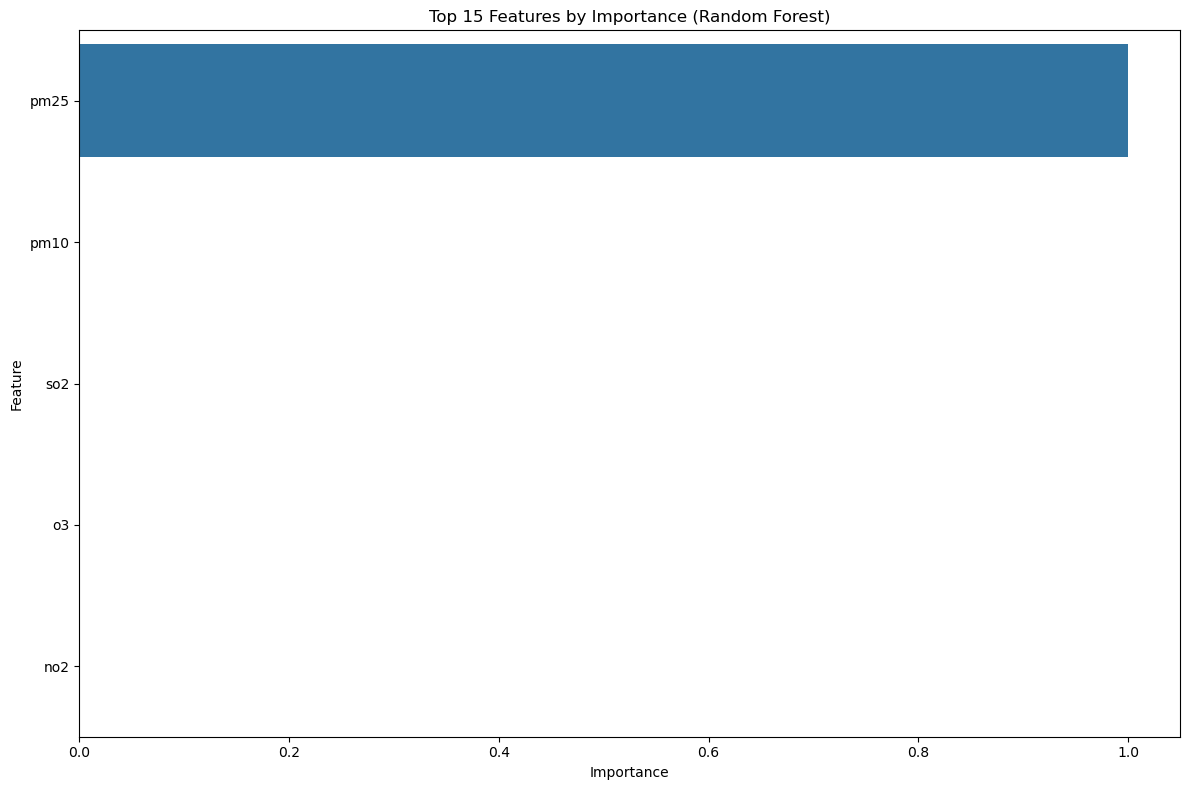

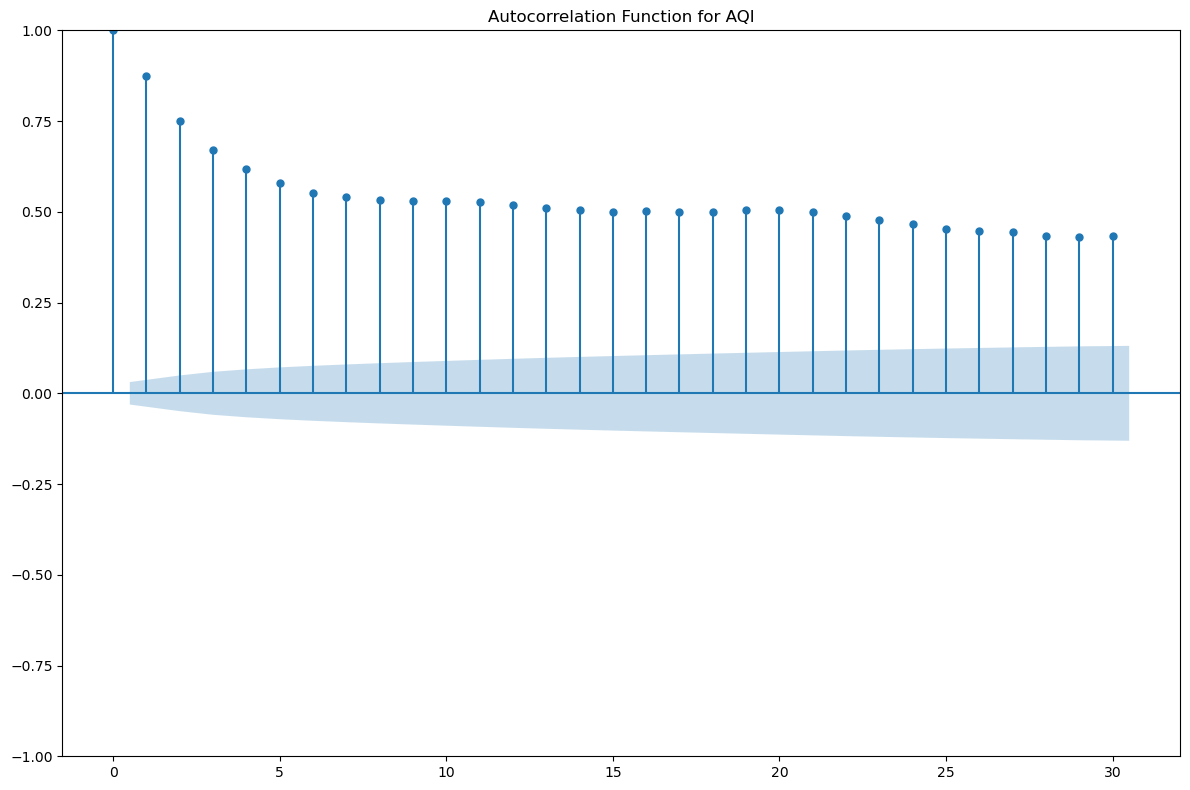

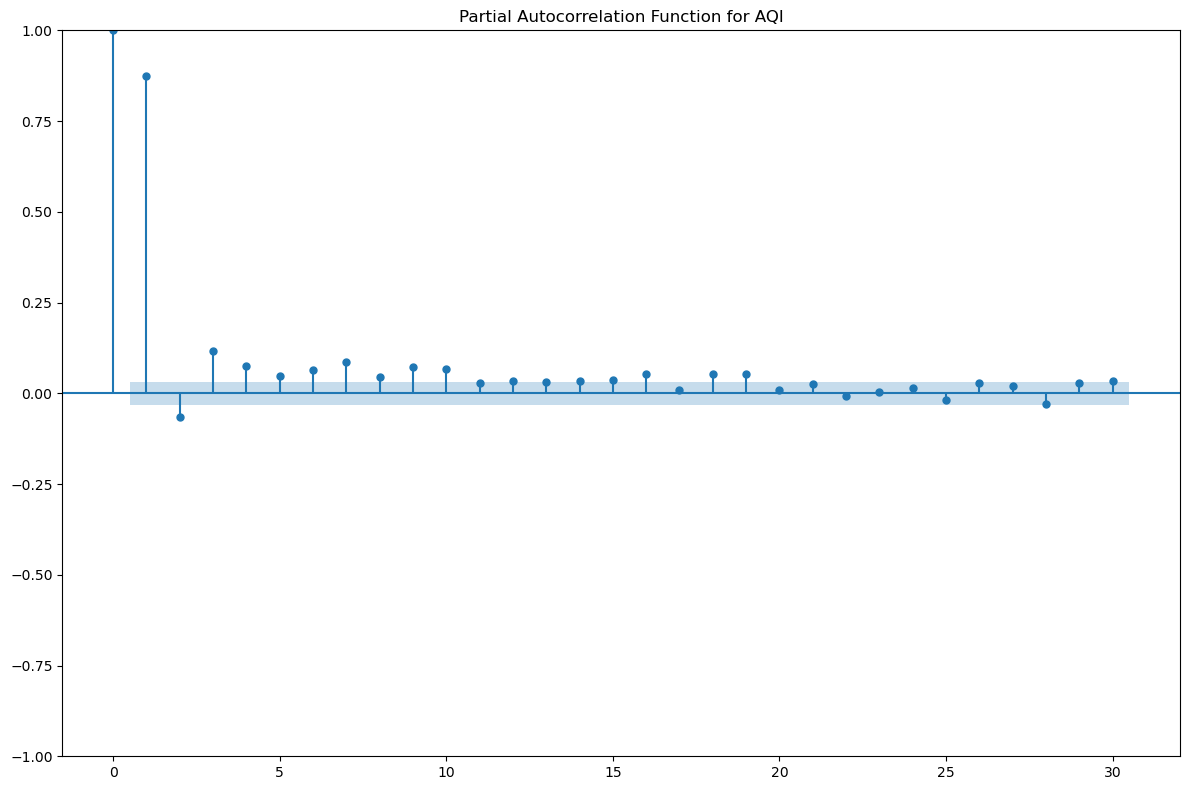

In [9]:
# 3.12 Feature importance using Random Forest
X = df[lag_columns]
y = df['AQI']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Features by Importance (Random Forest)')
plt.tight_layout()
plt.savefig('eda_plots/feature_importance.png')

print("\nTop 15 features by importance:")
print(feature_importance.head(15))

# 3.13 Autocorrelation and Partial Autocorrelation analysis
plt.figure(figsize=(12, 8))
plot_acf(df['AQI'], lags=30, ax=plt.gca())
plt.title('Autocorrelation Function for AQI')
plt.tight_layout()
plt.savefig('eda_plots/aqi_acf.png')

plt.figure(figsize=(12, 8))
plot_pacf(df['AQI'], lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function for AQI')
plt.tight_layout()
plt.savefig('eda_plots/aqi_pacf.png')

print("\nEDA completed. Plots saved to 'eda_plots' directory.")

In [10]:
# ===============================
# 4. Feature Selection and Engineering
# ===============================
print("\n--- Starting Feature Selection and Engineering ---")

# 4.1 Select features based on correlation analysis
# Get the top correlated features with AQI (both positive and negative)
aqi_corr = correlation_matrix['AQI'].abs().sort_values(ascending=False)
top_correlated = aqi_corr[1:16].index.tolist()  # Skip AQI itself, get top 15

print("\nTop 15 features by absolute correlation with AQI:")
for feature in top_correlated:
    print(f"{feature}: {correlation_matrix['AQI'][feature]:.4f}")

# 4.2 Feature selection using SelectKBest
X = df.drop(['AQI', 'next_day_AQI', 'date', 'season', 'weather_condition'], axis=1, errors='ignore')
X = X.select_dtypes(include=[np.number])  # Keep only numeric columns
y = df['next_day_AQI']

# Apply SelectKBest with f_regression
selector_f = SelectKBest(score_func=f_regression, k=20)
X_new_f = selector_f.fit_transform(X, y)
selected_features_f = X.columns[selector_f.get_support()]

print("\nTop 20 features selected by f_regression:")
scores_f = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector_f.scores_
}).sort_values('Score', ascending=False)
print(scores_f.head(20))

# Apply SelectKBest with mutual_info_regression
selector_mi = SelectKBest(score_func=mutual_info_regression, k=20)
X_new_mi = selector_mi.fit_transform(X, y)
selected_features_mi = X.columns[selector_mi.get_support()]

print("\nTop 20 features selected by mutual_info_regression:")
scores_mi = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector_mi.scores_
}).sort_values('Score', ascending=False)
print(scores_mi.head(20))


--- Starting Feature Selection and Engineering ---

Top 15 features by absolute correlation with AQI:
pm25: 0.9997
pm10_lag1: 0.8977
next_day_AQI: 0.8765
pm25_lag1: 0.8761
pm10_rolling3: 0.8496
pm10: 0.8311
pm25_rolling3: 0.8132
pm10_rolling7: 0.7673
pm25_rolling7: 0.7515
pm25_rolling14: 0.7233
pm10_rolling14: 0.7143
pm10_lag3: 0.6988
pm25_rolling30: 0.6933
pm25_lag3: 0.6727
pm10_rolling30: 0.6720

Top 20 features selected by f_regression:
            Feature         Score
1              pm10  16640.475521
0              pm25  13242.585645
19        pm10_lag1   7112.794893
35    pm10_rolling3   5315.380652
16        pm25_lag1   5238.125332
31    pm25_rolling3   4401.472558
36    pm10_rolling7   3931.153894
32    pm25_rolling7   3769.395423
33   pm25_rolling14   3665.632537
37   pm10_rolling14   3387.612158
34   pm25_rolling30   3349.593975
38   pm10_rolling30   2938.532770
15  day_of_year_cos   2909.959321
20        pm10_lag3   2651.964888
17        pm25_lag3   2527.912146
11        m


Top features selected by Random Forest importance:
1. pm10 (Importance: 0.7879)
2. pm25 (Importance: 0.0889)
3. pm25_pm10_ratio (Importance: 0.0149)
4. no2 (Importance: 0.0089)
5. o3 (Importance: 0.0062)
6. year (Importance: 0.0059)
7. pm10_lag1 (Importance: 0.0054)
8. day_of_year_cos (Importance: 0.0036)
9. o3_rolling30 (Importance: 0.0032)
10. o3_rolling3 (Importance: 0.0028)
11. pm10_std30 (Importance: 0.0026)
12. pm10_rolling3 (Importance: 0.0026)
13. no2_rolling30 (Importance: 0.0025)
14. pm25_std7 (Importance: 0.0023)
15. pm25_rolling30 (Importance: 0.0023)
16. pm25_std30 (Importance: 0.0022)
17. o3_rolling7 (Importance: 0.0022)
18. o3_std7 (Importance: 0.0022)
19. o3_std30 (Importance: 0.0021)
20. pm25_rolling14 (Importance: 0.0021)

Final selected features (appearing in at least 2 selection methods):
pm25
pm10_lag1
pm25_lag1
pm10_rolling3
pm10
pm25_rolling3
pm10_rolling7
pm25_rolling7
pm25_rolling14
pm10_rolling14
pm10_lag3
pm25_rolling30
pm25_lag3
pm10_rolling30
o3
day_of_yea

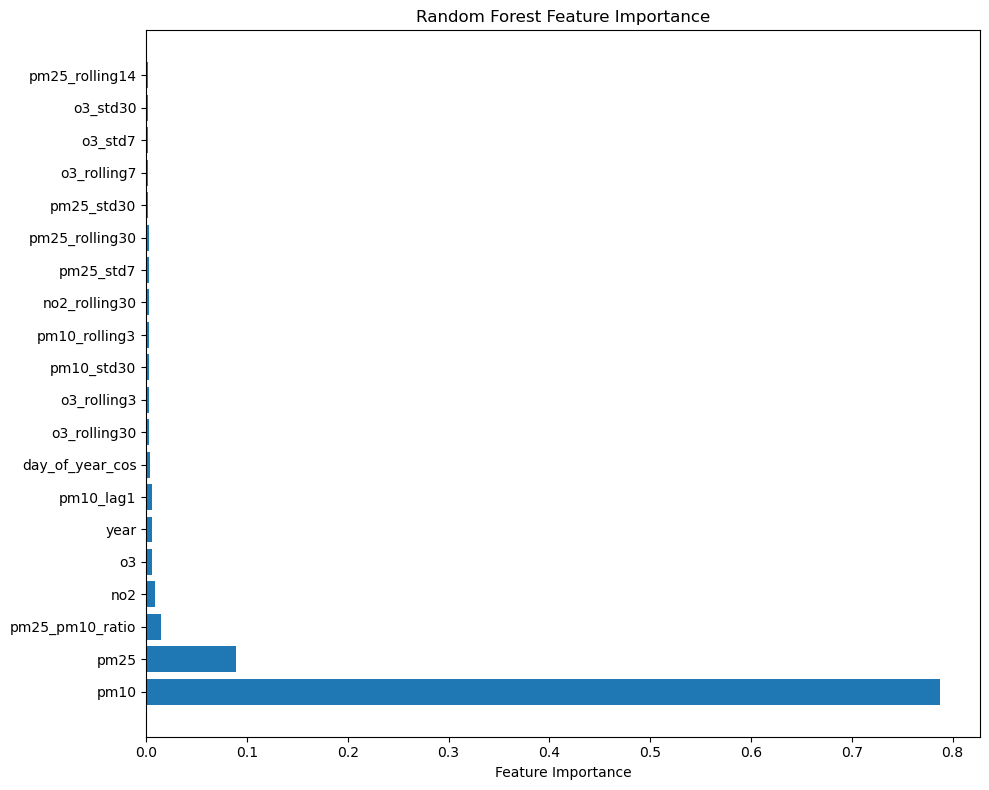

In [11]:
# Alternative approach without using RFE/RFECV
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances directly from Random Forest
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Select top 20 features
top_rf_features = [X.columns[i] for i in indices[:20]]

print("\nTop features selected by Random Forest importance:")
for i, feature in enumerate(top_rf_features):
    print(f"{i+1}. {feature} (Importance: {importances[indices[i]]:.4f})")

# Visualize feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(20), importances[indices[:20]], align='center')
plt.yticks(range(20), [X.columns[i] for i in indices[:20]])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig('eda_plots/rf_importance.png')

# 4.4 Combine feature selection methods
# Get features that appear in at least 2 of the 4 methods
all_selected_features = []
all_selected_features.extend(top_correlated)
all_selected_features.extend(selected_features_f)
all_selected_features.extend(selected_features_mi)
all_selected_features.extend(top_rf_features)  # Use RF features instead of RFE

# Count occurrences of each feature
from collections import Counter
feature_counts = Counter(all_selected_features)

# Select features that appear in at least 2 methods
final_features = [feature for feature, count in feature_counts.items() if count >= 2]

print("\nFinal selected features (appearing in at least 2 selection methods):")
for feature in final_features:
    print(feature)

# Add lag1 of AQI to final features (strong predictor for next day)
if 'AQI_lag1' not in final_features and 'AQI_lag1' in df.columns:
    final_features.append('AQI_lag1')
    print("Added AQI_lag1 to final features")


In [12]:
# ===============================
# 5. Model Preparation
# ===============================
print("\n--- Preparing Data for Modeling ---")

# Prepare final dataset with selected features
X = df[final_features]
y = df['next_day_AQI']

# Split data for training and testing
# Use time-based split for time series data
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



--- Preparing Data for Modeling ---
Training set: 3210 samples
Testing set: 803 samples


In [13]:
# ===============================
# 6. Model Building and Evaluation
# ===============================
print("\n--- Building and Evaluating Models ---")

# Create a directory for model results
os.makedirs('model_results', exist_ok=True)

# Function to evaluate and record model performance
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape*100:.2f}%")
    print(f"R²: {r2:.4f}")
    print(f"Explained Variance: {evs:.4f}")
    
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'Explained Variance': evs
    }

# Dictionary to store all model results
all_model_results = []


--- Building and Evaluating Models ---


In [14]:
# ===============================
# 6.1 Linear Models
# ===============================

# 6.1.1 Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
lr_results = evaluate_model("Linear Regression", y_test, y_pred_lr)
all_model_results.append(lr_results)

# 6.1.2 Ridge Regression with CV
ridge_cv = Ridge(random_state=42)
alphas = np.logspace(-6, 6, 13)
ridge_cv_params = {'alpha': alphas}
ridge_cv_grid = GridSearchCV(ridge_cv, ridge_cv_params, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
ridge_cv_grid.fit(X_train_scaled, y_train)
print(f"Best Ridge alpha: {ridge_cv_grid.best_params_['alpha']}")
y_pred_ridge = ridge_cv_grid.predict(X_test_scaled)
ridge_results = evaluate_model("Ridge Regression", y_test, y_pred_ridge)
all_model_results.append(ridge_results)

# 6.1.3 Lasso Regression with CV
lasso_cv = Lasso(random_state=42, max_iter=10000)
lasso_cv_params = {'alpha': alphas}
lasso_cv_grid = GridSearchCV(lasso_cv, lasso_cv_params, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
lasso_cv_grid.fit(X_train_scaled, y_train)
print(f"Best Lasso alpha: {lasso_cv_grid.best_params_['alpha']}")
y_pred_lasso = lasso_cv_grid.predict(X_test_scaled)
lasso_results = evaluate_model("Lasso Regression", y_test, y_pred_lasso)
all_model_results.append(lasso_results)

# 6.1.4 ElasticNet with CV
elasticnet_cv = ElasticNet(random_state=42, max_iter=10000)
elasticnet_cv_params = {
    'alpha': alphas,
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elasticnet_cv_grid = GridSearchCV(elasticnet_cv, elasticnet_cv_params, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
elasticnet_cv_grid.fit(X_train_scaled, y_train)
print(f"Best ElasticNet parameters: {elasticnet_cv_grid.best_params_}")
y_pred_elasticnet = elasticnet_cv_grid.predict(X_test_scaled)
elasticnet_results = evaluate_model("ElasticNet", y_test, y_pred_elasticnet)
all_model_results.append(elasticnet_results)



Linear Regression Performance:
MSE: 170.8214
RMSE: 13.0699
MAE: 9.1914
MAPE: 11.90%
R²: 0.8117
Explained Variance: 0.8119
Best Ridge alpha: 10.0

Ridge Regression Performance:
MSE: 168.0631
RMSE: 12.9639
MAE: 9.1578
MAPE: 11.87%
R²: 0.8147
Explained Variance: 0.8149
Best Lasso alpha: 0.01

Lasso Regression Performance:
MSE: 168.5888
RMSE: 12.9842
MAE: 9.1467
MAPE: 11.85%
R²: 0.8141
Explained Variance: 0.8143
Best ElasticNet parameters: {'alpha': 0.01, 'l1_ratio': 0.3}

ElasticNet Performance:
MSE: 166.9490
RMSE: 12.9209
MAE: 9.1568
MAPE: 11.86%
R²: 0.8159
Explained Variance: 0.8161


In [15]:
# ===============================
# 6.2 Tree-Based Models
# ===============================
from scipy.stats import randint, uniform, loguniform
rf_params = {
    'n_estimators': randint(50, 500),  # Expanded range
    'max_depth': [None, 5, 10, 20, 30, 40, 50],  # Added finer options
    'min_samples_split': randint(2, 30),  # Expanded range
    'min_samples_leaf': randint(1, 20),   # Expanded range
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]  # New parameter
}

rf_model = RandomForestRegressor(random_state=42)

rf_grid = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_params,
    n_iter=40,  # Increased iterations for a broader search
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_grid.fit(X_train_scaled, y_train)
print(f"Best Random Forest parameters: {rf_grid.best_params_}")
y_pred_rf = rf_grid.predict(X_test_scaled)
rf_results = evaluate_model("Random Forest", y_test, y_pred_rf)
all_model_results.append(rf_results)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Random Forest parameters: {'bootstrap': True, 'max_depth': 40, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 274}

Random Forest Performance:
MSE: 220.3051
RMSE: 14.8427
MAE: 9.6770
MAPE: 12.79%
R²: 0.7571
Explained Variance: 0.7588


In [16]:
# 6.2.2 Gradient Boosting with Hyperparameter Tuning
from scipy.stats import randint, uniform, loguniform
gb_params = {
    'n_estimators': randint(300, 1000),  # Increase the number of estimators
    'learning_rate': loguniform(0.005, 0.1),  # Lower learning rate range for better generalization
    'max_depth': randint(4, 10),  # Slightly deeper trees
    'min_samples_split': randint(5, 20),  # More focused range
    'min_samples_leaf': randint(3, 15),  # More focused range
    'subsample': uniform(0.7, 0.3),  # Higher subsample values (0.7-1.0)
    'max_features': uniform(0.6, 0.4)  # Focus on higher feature fractions
}

gb_model = GradientBoostingRegressor(
    random_state=42,
    validation_fraction=0.2,  # Add validation fraction
    n_iter_no_change=20,  # Early stopping
    tol=0.001  # Tolerance for early stopping
)

gb_grid = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=gb_params,
    n_iter=50,  # Reduced iterations but more focused search space
    cv=TimeSeriesSplit(n_splits=10),
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

gb_grid.fit(X_train_scaled, y_train)
print(f"Best Gradient Boosting parameters: {gb_grid.best_params_}")
y_pred_gb = gb_grid.predict(X_test_scaled)
gb_results = evaluate_model("Gradient Boosting", y_test, y_pred_gb)
all_model_results.append(gb_results)


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Gradient Boosting parameters: {'learning_rate': 0.08427986132210086, 'max_depth': 9, 'max_features': 0.687505687829228, 'min_samples_leaf': 10, 'min_samples_split': 13, 'n_estimators': 991, 'subsample': 0.8090888807137881}

Gradient Boosting Performance:
MSE: 150.9553
RMSE: 12.2864
MAE: 8.8571
MAPE: 11.95%
R²: 0.8336
Explained Variance: 0.8341


In [17]:
xgb_params = {
'n_estimators': randint(100, 500), # More trees for complex patterns
'learning_rate': uniform(0.01, 0.2), # Smaller learning rates often work better
'max_depth': randint(3, 8), # Control model complexity
'min_child_weight': randint(1, 6), # Helps with preventing overfitting
'gamma': uniform(0, 0.5), # Minimum loss reduction for split
'subsample': uniform(0.7, 0.3), # Fraction of samples for trees
'colsample_bytree': uniform(0.7, 0.3), # Fraction of features for trees
'reg_alpha': uniform(0, 1), # L1 regularization
'reg_lambda': uniform(1, 4) # L2 regularization
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up TimeSeriesSplit for time series data
tscv = TimeSeriesSplit(n_splits=6)

# RandomizedSearchCV for hyperparameter tuning
xgb_grid = RandomizedSearchCV(
estimator=xgb_model,
param_distributions=xgb_params,
n_iter=30, # Increased from 20 to 30 for better exploration
cv=tscv,
scoring='neg_mean_squared_error',
random_state=42,
verbose=1,
n_jobs=-1
)

xgb_grid.fit(X_train_scaled, y_train)
print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
y_pred_xgb = xgb_grid.predict(X_test_scaled)
xgb_results = evaluate_model("XGBoost", y_test, y_pred_xgb)
all_model_results.append(xgb_results)

Fitting 6 folds for each of 30 candidates, totalling 180 fits
Best XGBoost parameters: {'colsample_bytree': 0.7483663861762013, 'gamma': 0.46484882617128653, 'learning_rate': 0.17162407591288342, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 233, 'reg_alpha': 0.45653457048291024, 'reg_lambda': 1.8737617488673344, 'subsample': 0.8249529843611099}

XGBoost Performance:
MSE: 169.0159
RMSE: 13.0006
MAE: 9.2461
MAPE: 12.10%
R²: 0.8137
Explained Variance: 0.8139


In [18]:
lgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_samples': [1, 3, 5],
    'min_split_gain': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# Turn off verbose logging in LightGBM
lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1)
lgb_grid = RandomizedSearchCV(
    lgb_model, 
    lgb_params, 
    n_iter=20, 
    cv=TimeSeriesSplit(n_splits=5), 
    scoring='neg_mean_squared_error', 
    random_state=42
)
lgb_grid.fit(X_train_scaled, y_train)
print(f"Best LightGBM parameters: {lgb_grid.best_params_}")
y_pred_lgb = lgb_grid.predict(X_test_scaled)
lgb_results = evaluate_model("LightGBM", y_test, y_pred_lgb)
all_model_results.append(lgb_results)


Best LightGBM parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'min_split_gain': 0.1, 'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}

LightGBM Performance:
MSE: 164.9673
RMSE: 12.8440
MAE: 9.0112
MAPE: 12.08%
R²: 0.8181
Explained Variance: 0.8197


In [19]:
# 6.2.5 CatBoost
cb_model = cb.CatBoostRegressor(iterations=300, learning_rate=0.05, depth=2, random_state=42, verbose=0)
cb_model.fit(X_train_scaled, y_train)
y_pred_cb = cb_model.predict(X_test_scaled)
cb_results = evaluate_model("CatBoost", y_test, y_pred_cb)
all_model_results.append(cb_results)


CatBoost Performance:
MSE: 162.9310
RMSE: 12.7644
MAE: 9.0885
MAPE: 11.71%
R²: 0.8204
Explained Variance: 0.8213


Epoch 1/300
148/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7688.0249 - mae: 83.4224 - mse: 7687.9126
Epoch 1: val_loss improved from inf to 5771.25146, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7691.6084 - mae: 83.4671 - mse: 7691.4961 - val_loss: 5771.2515 - val_mae: 72.8547 - val_mse: 5771.1392 - learning_rate: 5.0000e-04
Epoch 2/300
143/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7416.8716 - mae: 82.7294 - mse: 7416.7573
Epoch 2: val_loss improved from 5771.25146 to 5701.12598, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7422.4243 - mae: 82.7780 - mse: 7422.3105 - val_loss: 5701.1260 - val_mae: 72.9856 - val_mse: 5701.0132 - learning_rate: 5.0000e-04
Epoch 3/300
149/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7140.1133 - mae: 81.6777 - mse: 7140.0010
Epoch 3: val_loss improved from 5701.12598 to 5691.19629, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7142.6460 - mae: 81.7036 - mse: 7142.5337 - val_loss: 5691.1963 - val_mae: 73.5067 - val_mse: 5691.0840 - learning_rate: 5.0000e-04
Epoch 4/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6811.0337 - mae: 80.2363 - mse: 6810.9219
Epoch 4: val_loss improved from 5691.19629 to 5655.80273, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6811.1318 - mae: 80.2376 - mse: 6811.0200 - val_loss: 5655.8027 - val_mae: 73.7680 - val_mse: 5655.6914 - learning_rate: 5.0000e-04
Epoch 5/300
128/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6440.6846 - mae: 78.3716 - mse: 6440.5708
Epoch 5: val_loss improved from 5655.80273 to 5493.91016, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6440.7397 - mae: 78.3979 - mse: 6440.6265 - val_loss: 5493.9102 - val_mae: 73.0288 - val_mse: 5493.7969 - learning_rate: 5.0000e-04
Epoch 6/300
138/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6041.5244 - mae: 76.2088 - mse: 6041.4106
Epoch 6: val_loss improved from 5493.91016 to 5262.73145, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6040.0981 - mae: 76.2148 - mse: 6039.9844 - val_loss: 5262.7314 - val_mae: 71.7548 - val_mse: 5262.6182 - learning_rate: 5.0000e-04
Epoch 7/300
142/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5628.6782 - mae: 73.7227 - mse: 5628.5659
Epoch 7: val_loss improved from 5262.73145 to 4993.48730, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5626.1914 - mae: 73.7194 - mse: 5626.0786 - val_loss: 4993.4873 - val_mae: 70.0458 - val_mse: 4993.3750 - learning_rate: 5.0000e-04
Epoch 8/300
142/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5209.9946 - mae: 70.9554 - mse: 5209.8828
Epoch 8: val_loss improved from 4993.48730 to 4699.82666, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5206.2554 - mae: 70.9440 - mse: 5206.1436 - val_loss: 4699.8267 - val_mae: 68.0281 - val_mse: 4699.7144 - learning_rate: 5.0000e-04
Epoch 9/300
135/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4786.6782 - mae: 67.9416 - mse: 4786.5654
Epoch 9: val_loss improved from 4699.82666 to 4356.98389, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4780.1499 - mae: 67.9151 - mse: 4780.0371 - val_loss: 4356.9839 - val_mae: 65.5023 - val_mse: 4356.8721 - learning_rate: 5.0000e-04
Epoch 10/300
149/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4350.8882 - mae: 64.6676 - mse: 4350.7749
Epoch 10: val_loss improved from 4356.98389 to 3917.29199, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4347.5947 - mae: 64.6520 - mse: 4347.4814 - val_loss: 3917.2920 - val_mae: 62.0574 - val_mse: 3917.1802 - learning_rate: 5.0000e-04
Epoch 11/300
145/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3921.4102 - mae: 61.1995 - mse: 3921.2971
Epoch 11: val_loss improved from 3917.29199 to 3398.80615, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3916.4978 - mae: 61.1738 - mse: 3916.3848 - val_loss: 3398.8062 - val_mae: 57.7245 - val_mse: 3398.6936 - learning_rate: 5.0000e-04
Epoch 12/300
143/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3485.7019 - mae: 57.5329 - mse: 3485.5884
Epoch 12: val_loss improved from 3398.80615 to 2962.34082, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3479.4756 - mae: 57.4978 - mse: 3479.3621 - val_loss: 2962.3408 - val_mae: 53.8060 - val_mse: 2962.2285 - learning_rate: 5.0000e-04
Epoch 13/300
143/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3055.7708 - mae: 53.6784 - mse: 3055.6577
Epoch 13: val_loss improved from 2962.34082 to 2452.05835, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3049.3660 - mae: 53.6382 - mse: 3049.2527 - val_loss: 2452.0583 - val_mae: 48.8609 - val_mse: 2451.9458 - learning_rate: 5.0000e-04
Epoch 14/300
149/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2626.2847 - mae: 49.6477 - mse: 2626.1711
Epoch 14: val_loss improved from 2452.05835 to 2095.95288, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2621.9993 - mae: 49.6184 - mse: 2621.8857 - val_loss: 2095.9529 - val_mae: 45.0299 - val_mse: 2095.8396 - learning_rate: 5.0000e-04
Epoch 15/300
145/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2231.5520 - mae: 45.5239 - mse: 2231.4382
Epoch 15: val_loss improved from 2095.95288 to 1746.73169, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2226.4116 - mae: 45.4843 - mse: 2226.2976 - val_loss: 1746.7317 - val_mae: 40.9650 - val_mse: 1746.6182 - learning_rate: 5.0000e-04
Epoch 16/300
144/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1870.0385 - mae: 41.3431 - mse: 1869.9253
Epoch 16: val_loss improved from 1746.73169 to 1401.28296, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1864.5140 - mae: 41.3001 - mse: 1864.4010 - val_loss: 1401.2830 - val_mae: 36.5196 - val_mse: 1401.1694 - learning_rate: 5.0000e-04
Epoch 17/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1542.9298 - mae: 37.1917 - mse: 1542.8169
Epoch 17: val_loss improved from 1401.28296 to 1068.88342, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1539.7570 - mae: 37.1664 - mse: 1539.6442 - val_loss: 1068.8834 - val_mae: 31.6157 - val_mse: 1068.7699 - learning_rate: 5.0000e-04
Epoch 18/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1248.5192 - mae: 33.1333 - mse: 1248.4058
Epoch 18: val_loss improved from 1068.88342 to 888.91412, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1245.9504 - mae: 33.1098 - mse: 1245.8372 - val_loss: 888.9141 - val_mae: 28.6438 - val_mse: 888.8005 - learning_rate: 5.0000e-04
Epoch 19/300
146/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1002.1751 - mae: 29.2521 - mse: 1002.0615
Epoch 19: val_loss improved from 888.91412 to 655.64771, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 998.9833 - mae: 29.2194 - mse: 998.8697 - val_loss: 655.6477 - val_mae: 24.3202 - val_mse: 655.5340 - learning_rate: 5.0000e-04
Epoch 20/300
146/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 795.6236 - mae: 25.4945 - mse: 795.5098
Epoch 20: val_loss improved from 655.64771 to 495.72464, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 792.8020 - mae: 25.4725 - mse: 792.6883 - val_loss: 495.7246 - val_mae: 20.8512 - val_mse: 495.6111 - learning_rate: 5.0000e-04
Epoch 21/300
148/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 629.6241 - mae: 22.2083 - mse: 629.5105
Epoch 21: val_loss improved from 495.72464 to 387.78107, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 627.4697 - mae: 22.1876 - mse: 627.3561 - val_loss: 387.7811 - val_mae: 18.1257 - val_mse: 387.6675 - learning_rate: 5.0000e-04
Epoch 22/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 497.1833 - mae: 19.1824 - mse: 497.0695
Epoch 22: val_loss improved from 387.78107 to 291.58878, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 496.1757 - mae: 19.1754 - mse: 496.0620 - val_loss: 291.5888 - val_mae: 15.3684 - val_mse: 291.4751 - learning_rate: 5.0000e-04
Epoch 23/300
147/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 393.7876 - mae: 16.7001 - mse: 393.6739
Epoch 23: val_loss improved from 291.58878 to 203.56229, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 392.3459 - mae: 16.6919 - mse: 392.2321 - val_loss: 203.5623 - val_mae: 12.4081 - val_mse: 203.4486 - learning_rate: 5.0000e-04
Epoch 24/300
142/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 322.8031 - mae: 14.7082 - mse: 322.6894
Epoch 24: val_loss improved from 203.56229 to 162.54820, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 321.3616 - mae: 14.6937 - mse: 321.2480 - val_loss: 162.5482 - val_mae: 10.8643 - val_mse: 162.4344 - learning_rate: 5.0000e-04
Epoch 25/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 264.4453 - mae: 13.0604 - mse: 264.3315
Epoch 25: val_loss improved from 162.54820 to 130.87720, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 264.2654 - mae: 13.0589 - mse: 264.1517 - val_loss: 130.8772 - val_mae: 9.4798 - val_mse: 130.7634 - learning_rate: 5.0000e-04
Epoch 26/300
144/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 227.0430 - mae: 11.7991 - mse: 226.9292
Epoch 26: val_loss improved from 130.87720 to 107.17259, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 225.9891 - mae: 11.7870 - mse: 225.8752 - val_loss: 107.1726 - val_mae: 8.3763 - val_mse: 107.0587 - learning_rate: 5.0000e-04
Epoch 27/300
147/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 197.3790 - mae: 10.9623 - mse: 197.2651
Epoch 27: val_loss improved from 107.17259 to 82.43288, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 196.5655 - mae: 10.9459 - mse: 196.4517 - val_loss: 82.4329 - val_mae: 7.0318 - val_mse: 82.3189 - learning_rate: 5.0000e-04
Epoch 28/300
142/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 179.8217 - mae: 10.4268 - mse: 179.7078
Epoch 28: val_loss improved from 82.43288 to 80.07436, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 178.5197 - mae: 10.3880 - mse: 178.4058 - val_loss: 80.0744 - val_mae: 6.8441 - val_mse: 79.9604 - learning_rate: 5.0000e-04
Epoch 29/300
138/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 167.2084 - mae: 9.9382 - mse: 167.0944
Epoch 29: val_loss improved from 80.07436 to 72.54117, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 165.6468 - mae: 9.8938 - mse: 165.5328 - val_loss: 72.5412 - val_mae: 6.4644 - val_mse: 72.4271 - learning_rate: 5.0000e-04
Epoch 30/300
138/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157.0186 - mae: 9.4673 - mse: 156.9046
Epoch 30: val_loss improved from 72.54117 to 70.14906, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 155.4394 - mae: 9.4295 - mse: 155.3253 - val_loss: 70.1491 - val_mae: 6.2772 - val_mse: 70.0349 - learning_rate: 5.0000e-04
Epoch 31/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 147.9577 - mae: 9.2490 - mse: 147.8436
Epoch 31: val_loss improved from 70.14906 to 66.45662, saving model to model_results/best_nn_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 147.7882 - mae: 9.2446 - mse: 147.6741 - val_loss: 66.4566 - val_mae: 6.0535 - val_mse: 66.3424 - learning_rate: 5.0000e-04
Epoch 32/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 141.8423 - mae: 9.1570 - mse: 141.7281
Epoch 32: val_loss did not improve from 66.45662
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 141.5644 - mae: 9.1483 - mse: 141.4502 - val_loss: 68.2565 - val_mae: 6.0946 - val_mse: 68.1422 - learning_rate: 5.0000e-04
Epoch 33/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143.1569 - mae: 9.1276 - mse: 143.0427
Epoch 33: val_loss did not improve from 66.45662
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 142.9142 - mae: 9.1199 - mse: 142.8000 - val_loss: 67.3148 - val_mae: 6.0020 - val_mse: 67.2006 - learning_rate: 5.0000e-04
Epoch 34/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141.2055 - mae: 9.1175 - mse: 141.0912
Epoch 34: val_loss did not improve from 66.45662
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s

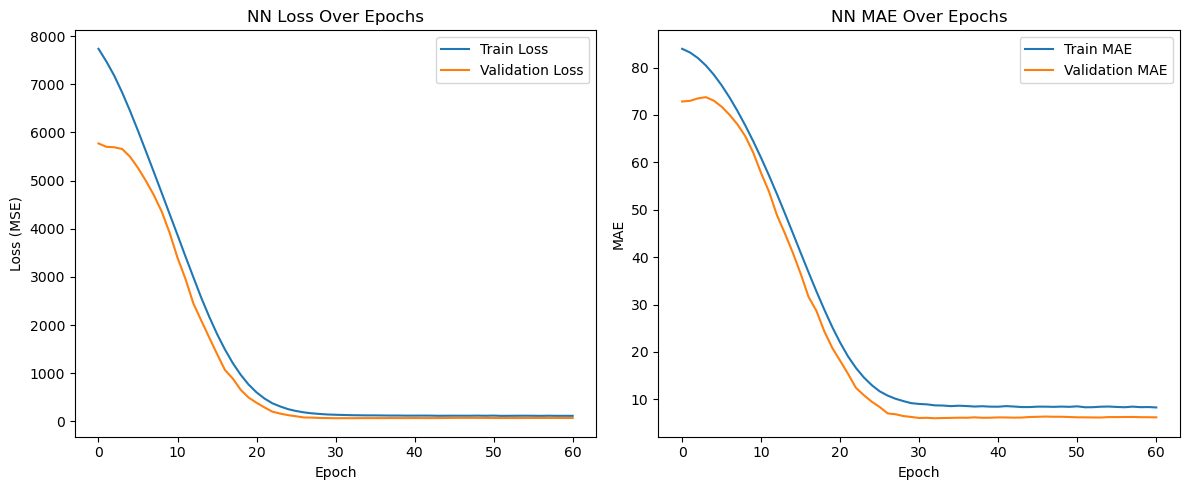

In [20]:
# ===============================
# 6.3 Neural Network Models
# ===============================

# 6.3.1 Simple Neural Network
# 6.3.1 Optimized Neural Network
def build_nn_model():
    model = Sequential([
        # Input layer with stronger regularization
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), 
              kernel_regularizer=l2(0.0005), 
              kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Hidden layers with decreasing size
        Dense(32, activation='relu', 
              kernel_regularizer=l2(0.0005), 
              kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.1),
        
        # Smaller final hidden layer
        Dense(16, activation='relu', 
              kernel_regularizer=l2(0.0005), 
              kernel_initializer='he_normal'),
        BatchNormalization(),
        
        # Output layer
        Dense(1)
    ])
    
    # Use a lower learning rate with AMSGrad for better convergence
    optimizer = Adam(learning_rate=0.0005, amsgrad=True)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
    return model

nn_model = build_nn_model()

# Improved callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=30,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  # More gradual reduction
    patience=10, 
    min_lr=0.00001,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'model_results/best_nn_model.h5', 
    save_best_only=True, 
    monitor='val_loss',
    verbose=1
)

# Train with class_weight to handle any imbalance in the target variable
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=300,  # Increased max epochs
    batch_size=16,  # Smaller batch size for better generalization with small dataset
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

y_pred_nn = nn_model.predict(X_test_scaled).flatten()
nn_results = evaluate_model("Neural Network", y_test, y_pred_nn)
all_model_results.append(nn_results)


# Plot training history for Simple Neural Network
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('NN Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('NN MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.savefig('model_results/nn_training_history.png')

In [21]:
input_dim = X_train_scaled.shape[1]

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

Training sequences shape: (3207, 3, 19)
Testing sequences shape: (800, 3, 19)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 3, 128)              │          43,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,233 (340.75 KB)

 Trainable params: 86,785 (339.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7729.7393 - mae: 84.1283 - mse: 7729.6958
Epoch 1: val_loss improved from inf to 5588.74463, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 7725.1177 - mae: 84.1176 - mse: 7725.0742 - val_loss: 5588.7446 - val_mae: 71.1432 - val_mse: 5588.7026 - learning_rate: 5.0000e-04
Epoch 2/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7339.2480 - mae: 83.0675 - mse: 7339.2051
Epoch 2: val_loss improved from 5588.74463 to 5547.29541, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7333.6338 - mae: 83.0455 - mse: 7333.5913 - val_loss: 5547.2954 - val_mae: 72.3200 - val_mse: 5547.2520 - learning_rate: 5.0000e-04
Epoch 3/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6912.3843 - mae: 81.2887 - mse: 6912.3408
Epoch 3: val_loss did not improve from 5547.29541
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6905.9023 - mae: 81.2578 - mse: 6905.8584 - val_loss: 5675.3691 - val_mae: 74.3858 - val_mse: 5675.3252 - learning_rate: 5.0000e-04
Epoch 4/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6416.4575 - mae: 78.7942 - mse: 6416.4136
Epoch 4: val_loss improved from 5547.29541 to 5538.80322, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6409.5459 - mae: 78.7548 - mse: 6409.5015 - val_loss: 5538.8032 - val_mae: 73.7973 - val_mse: 5538.7612 - learning_rate: 5.0000e-04
Epoch 5/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5881.1001 - mae: 75.6460 - mse: 5881.0557
Epoch 5: val_loss improved from 5538.80322 to 5081.13574, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5872.0850 - mae: 75.5877 - mse: 5872.0405 - val_loss: 5081.1357 - val_mae: 70.7423 - val_mse: 5081.0933 - learning_rate: 5.0000e-04
Epoch 6/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5299.6987 - mae: 71.8349 - mse: 5299.6553
Epoch 6: val_loss improved from 5081.13574 to 5007.66016, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5296.7559 - mae: 71.8133 - mse: 5296.7119 - val_loss: 5007.6602 - val_mae: 70.1249 - val_mse: 5007.6167 - learning_rate: 5.0000e-04
Epoch 7/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4696.8452 - mae: 67.4737 - mse: 4696.8018
Epoch 7: val_loss improved from 5007.66016 to 4096.22461, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4695.8267 - mae: 67.4658 - mse: 4695.7832 - val_loss: 4096.2246 - val_mae: 63.3950 - val_mse: 4096.1812 - learning_rate: 5.0000e-04
Epoch 8/300
155/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4061.6445 - mae: 62.6047 - mse: 4061.6013
Epoch 8: val_loss improved from 4096.22461 to 3322.78223, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4054.2759 - mae: 62.5445 - mse: 4054.2327 - val_loss: 3322.7822 - val_mae: 57.0517 - val_mse: 3322.7390 - learning_rate: 5.0000e-04
Epoch 9/300
155/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3403.8245 - mae: 57.1431 - mse: 3403.7810
Epoch 9: val_loss improved from 3322.78223 to 2633.28711, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3396.6016 - mae: 57.0781 - mse: 3396.5581 - val_loss: 2633.2871 - val_mae: 50.6407 - val_mse: 2633.2429 - learning_rate: 5.0000e-04
Epoch 10/300
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2760.8984 - mae: 51.2522 - mse: 2760.8545
Epoch 10: val_loss improved from 2633.28711 to 2060.03076, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2758.9622 - mae: 51.2323 - mse: 2758.9182 - val_loss: 2060.0308 - val_mae: 44.6448 - val_mse: 2059.9868 - learning_rate: 5.0000e-04
Epoch 11/300
150/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2181.6218 - mae: 45.3039 - mse: 2181.5784
Epoch 11: val_loss improved from 2060.03076 to 1668.20947, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2171.6099 - mae: 45.1888 - mse: 2171.5662 - val_loss: 1668.2095 - val_mae: 39.9740 - val_mse: 1668.1661 - learning_rate: 5.0000e-04
Epoch 12/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1661.2511 - mae: 39.1969 - mse: 1661.2072
Epoch 12: val_loss improved from 1668.20947 to 1020.66443, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1654.8193 - mae: 39.1098 - mse: 1654.7754 - val_loss: 1020.6644 - val_mae: 30.8915 - val_mse: 1020.6206 - learning_rate: 5.0000e-04
Epoch 13/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1222.5826 - mae: 33.1824 - mse: 1222.5389
Epoch 13: val_loss improved from 1020.66443 to 755.68433, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1220.3019 - mae: 33.1441 - mse: 1220.2581 - val_loss: 755.6843 - val_mae: 26.3037 - val_mse: 755.6406 - learning_rate: 5.0000e-04
Epoch 14/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 878.3076 - mae: 27.5910 - mse: 878.2640
Epoch 14: val_loss improved from 755.68433 to 444.19632, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 875.6404 - mae: 27.5382 - mse: 875.5968 - val_loss: 444.1963 - val_mae: 19.6591 - val_mse: 444.1524 - learning_rate: 5.0000e-04
Epoch 15/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 613.6187 - mae: 22.5003 - mse: 613.5750
Epoch 15: val_loss improved from 444.19632 to 373.64178, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 611.0947 - mae: 22.4401 - mse: 611.0509 - val_loss: 373.6418 - val_mae: 17.8263 - val_mse: 373.5979 - learning_rate: 5.0000e-04
Epoch 16/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 430.4189 - mae: 18.1842 - mse: 430.3750
Epoch 16: val_loss improved from 373.64178 to 219.48462, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 428.6766 - mae: 18.1351 - mse: 428.6326 - val_loss: 219.4846 - val_mae: 13.0824 - val_mse: 219.4406 - learning_rate: 5.0000e-04
Epoch 17/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 309.8354 - mae: 14.8329 - mse: 309.7914
Epoch 17: val_loss improved from 219.48462 to 163.83176, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 308.6432 - mae: 14.7945 - mse: 308.5992 - val_loss: 163.8318 - val_mae: 11.0192 - val_mse: 163.7877 - learning_rate: 5.0000e-04
Epoch 18/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 224.7669 - mae: 12.1287 - mse: 224.7228
Epoch 18: val_loss improved from 163.83176 to 130.24203, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 224.4620 - mae: 12.1178 - mse: 224.4178 - val_loss: 130.2420 - val_mae: 9.5856 - val_mse: 130.1979 - learning_rate: 5.0000e-04
Epoch 19/300
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 175.6535 - mae: 10.4637 - mse: 175.6093
Epoch 19: val_loss improved from 130.24203 to 92.38184, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 175.4206 - mae: 10.4559 - mse: 175.3765 - val_loss: 92.3818 - val_mae: 7.6762 - val_mse: 92.3376 - learning_rate: 5.0000e-04
Epoch 20/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 148.3052 - mae: 9.4870 - mse: 148.2611
Epoch 20: val_loss improved from 92.38184 to 67.99500, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 148.1923 - mae: 9.4826 - mse: 148.1481 - val_loss: 67.9950 - val_mae: 6.2229 - val_mse: 67.9508 - learning_rate: 5.0000e-04
Epoch 21/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 128.7406 - mae: 8.7059 - mse: 128.6964
Epoch 21: val_loss improved from 67.99500 to 65.26501, saving model to model_results/best_lstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 128.7081 - mae: 8.7055 - mse: 128.6638 - val_loss: 65.2650 - val_mae: 6.0903 - val_mse: 65.2207 - learning_rate: 5.0000e-04
Epoch 22/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 119.3480 - mae: 8.3991 - mse: 119.3036
Epoch 22: val_loss did not improve from 65.26501
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 119.3362 - mae: 8.3999 - mse: 119.2919 - val_loss: 65.7841 - val_mae: 6.0306 - val_mse: 65.7397 - learning_rate: 5.0000e-04
Epoch 23/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 115.3609 - mae: 8.3558 - mse: 115.3166
Epoch 23: val_loss did not improve from 65.26501
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 115.3562 - mae: 8.3585 - mse: 115.3118 - val_loss: 69.4487 - val_mae: 6.2453 - val_mse: 69.4043 - learning_rate: 5.0000e-04
Epoch 24/300
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 109.9021 - mae: 8.0937 - mse: 109.8577
Epoch 24: val_loss improved from 65.26501 to 63.63417, saving model to model_res

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 109.8752 - mae: 8.0934 - mse: 109.8308 - val_loss: 63.6342 - val_mae: 5.8427 - val_mse: 63.5897 - learning_rate: 5.0000e-04
Epoch 25/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 108.2470 - mae: 8.0448 - mse: 108.2024
Epoch 25: val_loss did not improve from 63.63417
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 108.2787 - mae: 8.0476 - mse: 108.2342 - val_loss: 64.7580 - val_mae: 5.8790 - val_mse: 64.7134 - learning_rate: 5.0000e-04
Epoch 26/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 103.1801 - mae: 7.8716 - mse: 103.1356
Epoch 26: val_loss did not improve from 63.63417
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 103.2208 - mae: 7.8735 - mse: 103.1763 - val_loss: 64.6337 - val_mae: 5.8727 - val_mse: 64.5891 - learning_rate: 5.0000e-04
Epoch 27/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 104.8515 - mae: 7.9049 - mse: 104.8069
Epoch 27: val_loss did not improve from 63.63417
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 99.8439 - mae: 7.8349 - mse: 99.7992 - val_loss: 63.2087 - val_mae: 5.7578 - val_mse: 63.1640 - learning_rate: 5.0000e-04
Epoch 31/300
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 99.2518 - mae: 7.7636 - mse: 99.2071
Epoch 31: val_loss did not improve from 63.20868
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 99.2891 - mae: 7.7648 - mse: 99.2444 - val_loss: 63.9213 - val_mae: 5.8356 - val_mse: 63.8766 - learning_rate: 5.0000e-04
Epoch 32/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 97.0509 - mae: 7.6530 - mse: 97.0062
Epoch 32: val_loss did not improve from 63.20868
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 97.1831 - mae: 7.6588 - mse: 97.1383 - val_loss: 66.3519 - val_mae: 5.9716 - val_mse: 66.3071 - learning_rate: 5.0000e-04
Epoch 33/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 98.0043 - mae: 7.7987 - mse: 97.9595
Epoch 33: val_loss did not improve from 63.20868
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - 

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 95.5046 - mae: 7.6518 - mse: 95.4597 - val_loss: 62.7222 - val_mae: 5.7630 - val_mse: 62.6773 - learning_rate: 5.0000e-04
Epoch 38/300
155/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 96.4493 - mae: 7.6829 - mse: 96.4043
Epoch 38: val_loss did not improve from 62.72222
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 96.4911 - mae: 7.6842 - mse: 96.4462 - val_loss: 66.8951 - val_mae: 6.0707 - val_mse: 66.8501 - learning_rate: 5.0000e-04
Epoch 39/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 94.3316 - mae: 7.6039 - mse: 94.2867
Epoch 39: val_loss did not improve from 62.72222
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 94.3524 - mae: 7.6050 - mse: 94.3075 - val_loss: 64.2359 - val_mae: 5.8446 - val_mse: 64.1909 - learning_rate: 5.0000e-04
Epoch 40/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 95.2608 - mae: 7.7083 - mse: 95.2158
Epoch 40: val_loss did not improve from 62.72222
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - 

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 91.8167 - mae: 7.5297 - mse: 91.7717 - val_loss: 62.5062 - val_mae: 5.6862 - val_mse: 62.4612 - learning_rate: 5.0000e-04
Epoch 43/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 91.3540 - mae: 7.4767 - mse: 91.3091
Epoch 43: val_loss did not improve from 62.50617
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 91.4657 - mae: 7.4811 - mse: 91.4207 - val_loss: 63.9467 - val_mae: 5.7403 - val_mse: 63.9017 - learning_rate: 5.0000e-04
Epoch 44/300
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 91.3431 - mae: 7.4527 - mse: 91.2981
Epoch 44: val_loss did not improve from 62.50617
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 91.3596 - mae: 7.4538 - mse: 91.3146 - val_loss: 68.3605 - val_mae: 6.1404 - val_mse: 68.3155 - learning_rate: 5.0000e-04
Epoch 45/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 93.1921 - mae: 7.6353 - mse: 93.1471
Epoch 45: val_loss did not improve from 62.50617
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - 

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 91.7100 - mae: 7.5038 - mse: 91.6649 - val_loss: 62.2257 - val_mae: 5.7231 - val_mse: 62.1806 - learning_rate: 5.0000e-04
Epoch 48/300
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 92.8947 - mae: 7.5615 - mse: 92.8496
Epoch 48: val_loss did not improve from 62.22573
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 92.9404 - mae: 7.5634 - mse: 92.8953 - val_loss: 64.7504 - val_mae: 5.9563 - val_mse: 64.7053 - learning_rate: 5.0000e-04
Epoch 49/300
160/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 90.3172 - mae: 7.4355 - mse: 90.2721
Epoch 49: val_loss did not improve from 62.22573
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 90.3279 - mae: 7.4356 - mse: 90.2828 - val_loss: 65.5970 - val_mae: 5.9201 - val_mse: 65.5519 - learning_rate: 5.0000e-04
Epoch 50/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 90.6605 - mae: 7.5155 - mse: 90.6154
Epoch 50: val_loss did not improve from 62.22573
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - 

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 89.3345 - mae: 7.4084 - mse: 89.2893 - val_loss: 61.9735 - val_mae: 5.7165 - val_mse: 61.9284 - learning_rate: 5.0000e-04
Epoch 55/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 89.5694 - mae: 7.3897 - mse: 89.5242
Epoch 55: val_loss did not improve from 61.97355
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 89.5912 - mae: 7.3903 - mse: 89.5460 - val_loss: 64.4190 - val_mae: 5.8193 - val_mse: 64.3738 - learning_rate: 5.0000e-04
Epoch 56/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 88.3268 - mae: 7.4395 - mse: 88.2816
Epoch 56: val_loss did not improve from 61.97355
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 88.3242 - mae: 7.4366 - mse: 88.2790 - val_loss: 63.5295 - val_mae: 5.7516 - val_mse: 63.4843 - learning_rate: 5.0000e-04
Epoch 57/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 87.3518 - mae: 7.3421 - mse: 87.3066
Epoch 57: val_loss did not improve from 61.97355
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - 

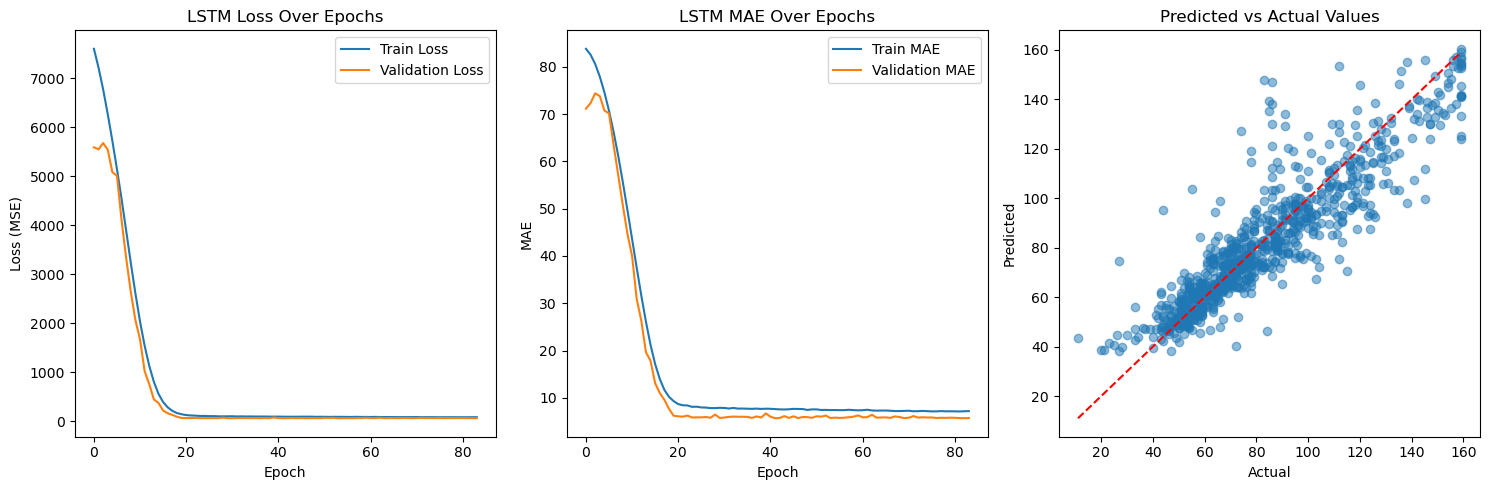

In [22]:
# 6.3.2 Enhanced LSTM Model
def build_lstm_model(input_shape, units=64):
    model = Sequential([
        # Bidirectional LSTM can capture patterns in both directions
        Bidirectional(LSTM(units, return_sequences=True, activation='tanh', 
                          recurrent_dropout=0.1), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        
        # Second LSTM layer for more complex pattern recognition
        Bidirectional(LSTM(units//2, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),
        
        # Dense layers for final prediction
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dense(1)
    ])
    
    # Use a lower learning rate with AMSGrad for better convergence
    optimizer = Adam(learning_rate=0.0005, amsgrad=True)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
    
    return model

# Create sequences for LSTM (samples, timesteps, features)
# Using multiple timesteps instead of just 1
def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps - 1])  # Use .iloc for positional indexing
    return np.array(Xs), np.array(ys)



# Create sequences with multiple timesteps
time_steps = 3  # Look back 3 days to predict the next day
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Testing sequences shape: {X_test_seq.shape}")

# Build and train the enhanced LSTM model
lstm_model = build_lstm_model((time_steps, X_train_scaled.shape[1]))
lstm_model.summary()  # Print model architecture

# Improved callbacks
early_stopping_lstm = EarlyStopping(
    monitor='val_loss', 
    patience=30,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr_lstm = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  # More gradual reduction
    patience=10, 
    min_lr=0.00001,
    verbose=1
)

model_checkpoint_lstm = ModelCheckpoint(
    'model_results/best_lstm_model.h5', 
    save_best_only=True, 
    monitor='val_loss',
    verbose=1
)

# Train with class_weight to handle any imbalance in the target variable
history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=300,  # Increased max epochs
    batch_size=16,  # Smaller batch size for better generalization with small dataset
    validation_split=0.2,
    callbacks=[early_stopping_lstm, reduce_lr_lstm, model_checkpoint_lstm],
    verbose=1
)

# Evaluate the model
y_pred_lstm = lstm_model.predict(X_test_seq).flatten()
lstm_results = evaluate_model("Enhanced LSTM", y_test_seq, y_pred_lstm)
all_model_results.append(lstm_results)

# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_lstm.history['mae'], label='Train MAE')
plt.plot(history_lstm.history['val_mae'], label='Validation MAE')
plt.title('LSTM MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(y_test_seq, y_pred_lstm, alpha=0.5)
plt.plot([min(y_test_seq), max(y_test_seq)], [min(y_test_seq), max(y_test_seq)], 'r--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.savefig('model_results/lstm_training_history.png')
plt.show()


Training sequences shape: (3207, 3, 19)
Testing sequences shape: (800, 3, 19)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 3, 128)              │          43,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,233 (340.75 KB)

 Trainable params: 86,785 (339.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/300
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7738.8755 - mae: 84.1323 - mse: 7738.8335
Epoch 1: val_loss improved from inf to 5641.48096, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 7734.9570 - mae: 84.1232 - mse: 7734.9146 - val_loss: 5641.4810 - val_mae: 71.4256 - val_mse: 5641.4380 - learning_rate: 5.0000e-04
Epoch 2/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7352.7085 - mae: 83.0956 - mse: 7352.6675
Epoch 2: val_loss improved from 5641.48096 to 5605.88379, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7347.0186 - mae: 83.0738 - mse: 7346.9775 - val_loss: 5605.8838 - val_mae: 72.7315 - val_mse: 5605.8403 - learning_rate: 5.0000e-04
Epoch 3/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6925.4224 - mae: 81.3315 - mse: 6925.3799
Epoch 3: val_loss did not improve from 5605.88379
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6917.4697 - mae: 81.2936 - mse: 6917.4272 - val_loss: 5717.4688 - val_mae: 74.6210 - val_mse: 5717.4248 - learning_rate: 5.0000e-04
Epoch 4/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6421.0669 - mae: 78.8002 - mse: 6421.0225
Epoch 4: val_loss improved from 5605.88379 to 5446.04590, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6420.1655 - mae: 78.7949 - mse: 6420.1211 - val_loss: 5446.0459 - val_mae: 73.1528 - val_mse: 5446.0029 - learning_rate: 5.0000e-04
Epoch 5/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5884.2017 - mae: 75.6759 - mse: 5884.1582
Epoch 5: val_loss improved from 5446.04590 to 5354.03662, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5876.9985 - mae: 75.6287 - mse: 5876.9551 - val_loss: 5354.0366 - val_mae: 72.6150 - val_mse: 5353.9932 - learning_rate: 5.0000e-04
Epoch 6/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5311.5391 - mae: 71.9103 - mse: 5311.4971
Epoch 6: val_loss improved from 5354.03662 to 4733.77051, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5303.9639 - mae: 71.8559 - mse: 5303.9219 - val_loss: 4733.7705 - val_mae: 68.2088 - val_mse: 4733.7280 - learning_rate: 5.0000e-04
Epoch 7/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4704.7046 - mae: 67.5289 - mse: 4704.6626
Epoch 7: val_loss improved from 4733.77051 to 3814.96533, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4703.6914 - mae: 67.5210 - mse: 4703.6489 - val_loss: 3814.9653 - val_mae: 61.1787 - val_mse: 3814.9216 - learning_rate: 5.0000e-04
Epoch 8/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4066.1858 - mae: 62.6520 - mse: 4066.1426
Epoch 8: val_loss improved from 3814.96533 to 3231.52441, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4062.9131 - mae: 62.6252 - mse: 4062.8701 - val_loss: 3231.5244 - val_mae: 56.2138 - val_mse: 3231.4812 - learning_rate: 5.0000e-04
Epoch 9/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3409.3513 - mae: 57.2406 - mse: 3409.3083
Epoch 9: val_loss improved from 3231.52441 to 2554.09985, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3400.1946 - mae: 57.1576 - mse: 3400.1514 - val_loss: 2554.0999 - val_mae: 49.8160 - val_mse: 2554.0564 - learning_rate: 5.0000e-04
Epoch 10/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2763.1741 - mae: 51.3634 - mse: 2763.1306
Epoch 10: val_loss improved from 2554.09985 to 2049.81519, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2757.4785 - mae: 51.3045 - mse: 2757.4351 - val_loss: 2049.8152 - val_mae: 44.5288 - val_mse: 2049.7720 - learning_rate: 5.0000e-04
Epoch 11/300
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2174.5884 - mae: 45.2914 - mse: 2174.5449
Epoch 11: val_loss improved from 2049.81519 to 1524.38782, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2170.3049 - mae: 45.2414 - mse: 2170.2617 - val_loss: 1524.3878 - val_mae: 38.1594 - val_mse: 1524.3440 - learning_rate: 5.0000e-04
Epoch 12/300
158/161 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1655.1124 - mae: 39.1843 - mse: 1655.0685
Epoch 12: val_loss improved from 1524.38782 to 1113.35168, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1652.2239 - mae: 39.1445 - mse: 1652.1799 - val_loss: 1113.3517 - val_mae: 32.3437 - val_mse: 1113.3080 - learning_rate: 5.0000e-04
Epoch 13/300
159/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1220.1456 - mae: 33.2221 - mse: 1220.1024
Epoch 13: val_loss improved from 1113.35168 to 765.26135, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1218.3583 - mae: 33.1932 - mse: 1218.3149 - val_loss: 765.2614 - val_mae: 26.4292 - val_mse: 765.2178 - learning_rate: 5.0000e-04
Epoch 14/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 878.6389 - mae: 27.6243 - mse: 878.5954
Epoch 14: val_loss improved from 765.26135 to 583.01166, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 875.8880 - mae: 27.5721 - mse: 875.8445 - val_loss: 583.0117 - val_mae: 22.7723 - val_mse: 582.9681 - learning_rate: 5.0000e-04
Epoch 15/300
157/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 616.6518 - mae: 22.4695 - mse: 616.6082
Epoch 15: val_loss improved from 583.01166 to 301.03885, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 614.9843 - mae: 22.4317 - mse: 614.9407 - val_loss: 301.0388 - val_mae: 15.6945 - val_mse: 300.9952 - learning_rate: 5.0000e-04
Epoch 16/300
156/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 431.4423 - mae: 18.1506 - mse: 431.3987
Epoch 16: val_loss improved from 301.03885 to 221.73737, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 430.1202 - mae: 18.1138 - mse: 430.0766 - val_loss: 221.7374 - val_mae: 13.0188 - val_mse: 221.6937 - learning_rate: 5.0000e-04
Epoch 17/300
150/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 308.8673 - mae: 14.7697 - mse: 308.8235
Epoch 17: val_loss improved from 221.73737 to 143.50140, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 307.1280 - mae: 14.7146 - mse: 307.0843 - val_loss: 143.5014 - val_mae: 9.7526 - val_mse: 143.4576 - learning_rate: 5.0000e-04
Epoch 18/300
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 226.4344 - mae: 12.1434 - mse: 226.3907
Epoch 18: val_loss improved from 143.50140 to 116.26270, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 226.3472 - mae: 12.1404 - mse: 226.3034 - val_loss: 116.2627 - val_mae: 8.7465 - val_mse: 116.2189 - learning_rate: 5.0000e-04
Epoch 19/300
155/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 174.0943 - mae: 10.3159 - mse: 174.0506
Epoch 19: val_loss improved from 116.26270 to 93.04416, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 173.8019 - mae: 10.3092 - mse: 173.7581 - val_loss: 93.0442 - val_mae: 7.6322 - val_mse: 93.0003 - learning_rate: 5.0000e-04
Epoch 20/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 148.3566 - mae: 9.5434 - mse: 148.3128
Epoch 20: val_loss improved from 93.04416 to 82.11663, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 148.0619 - mae: 9.5260 - mse: 148.0181 - val_loss: 82.1166 - val_mae: 6.9683 - val_mse: 82.0728 - learning_rate: 5.0000e-04
Epoch 21/300
152/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 129.2999 - mae: 8.8036 - mse: 129.2560
Epoch 21: val_loss did not improve from 82.11663
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 129.2500 - mae: 8.8012 - mse: 129.2062 - val_loss: 82.5596 - val_mae: 6.9804 - val_mse: 82.5157 - learning_rate: 5.0000e-04
Epoch 22/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 122.0475 - mae: 8.6021 - mse: 122.0036
Epoch 22: val_loss improved from 82.11663 to 79.65957, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 121.9756 - mae: 8.5948 - mse: 121.9318 - val_loss: 79.6596 - val_mae: 6.8550 - val_mse: 79.6156 - learning_rate: 5.0000e-04
Epoch 23/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 111.0272 - mae: 8.1205 - mse: 110.9833
Epoch 23: val_loss improved from 79.65957 to 72.44828, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 111.0339 - mae: 8.1199 - mse: 110.9899 - val_loss: 72.4483 - val_mae: 6.2120 - val_mse: 72.4043 - learning_rate: 5.0000e-04
Epoch 24/300
149/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 110.4689 - mae: 8.0759 - mse: 110.4249
Epoch 24: val_loss did not improve from 72.44828
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 110.4142 - mae: 8.0769 - mse: 110.3702 - val_loss: 75.4571 - val_mae: 6.2014 - val_mse: 75.4131 - learning_rate: 5.0000e-04
Epoch 25/300
153/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 103.8055 - mae: 7.8756 - mse: 103.7614
Epoch 25: val_loss improved from 72.44828 to 72.21268, saving model to model_results/best_bilstm_model.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 103.8597 - mae: 7.8786 - mse: 103.8156 - val_loss: 72.2127 - val_mae: 6.1561 - val_mse: 72.1686 - learning_rate: 5.0000e-04
Epoch 26/300
154/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 102.8887 - mae: 7.9117 - mse: 102.8446
Epoch 26: val_loss did not improve from 72.21268
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 102.9851 - mae: 7.9148 - mse: 102.9410 - val_loss: 72.9358 - val_mae: 6.2536 - val_mse: 72.8917 - learning_rate: 5.0000e-04
Epoch 27/300
151/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 101.6474 - mae: 7.8366 - mse: 101.6032
Epoch 27: val_loss did not improve from 72.21268
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 101.7223 - mae: 7.8412 - mse: 101.6781 - val_loss: 75.0258 - val_mae: 6.2638 - val_mse: 74.9816 - learning_rate: 5.0000e-04
Epoch 28/300
150/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 101.9076 - mae: 7.9823 - mse: 101.8634
Epoch 28: val_loss did not improve from 72.21268
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s

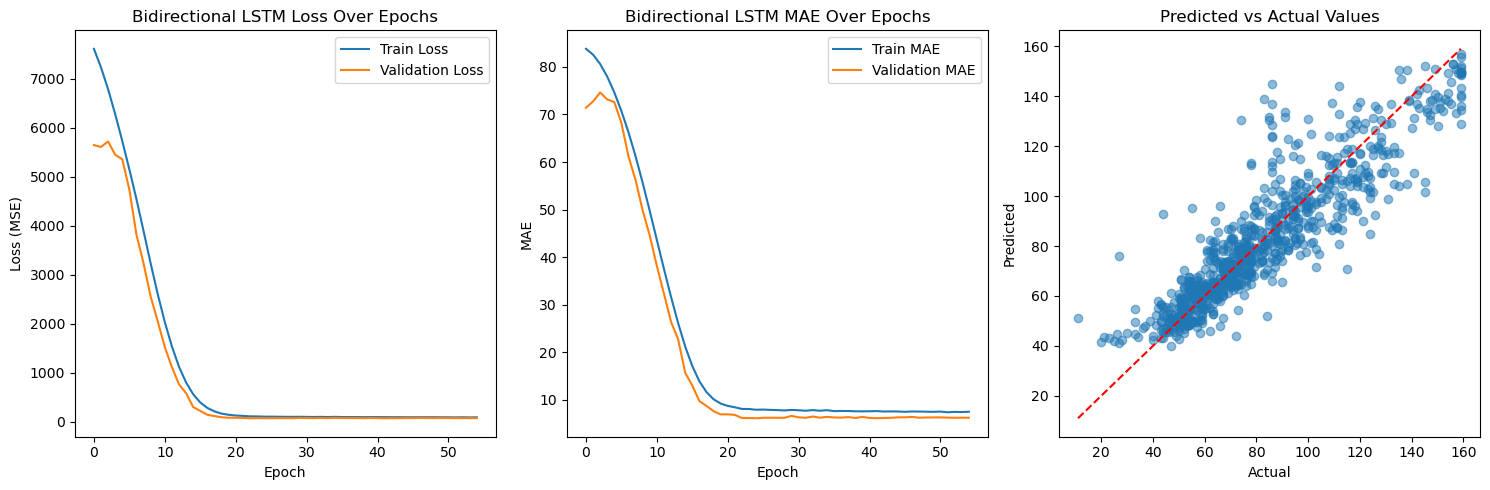

In [23]:
# 6.3.3 Enhanced Bidirectional LSTM Model
def build_bilstm_model(input_shape, units=64):
    model = Sequential([
        # First Bidirectional LSTM layer with return sequences
        Bidirectional(LSTM(units, return_sequences=True, activation='tanh', 
                           recurrent_dropout=0.1), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        
        # Second Bidirectional LSTM layer
        Bidirectional(LSTM(units//2, activation='tanh')),
        BatchNormalization(),
        Dropout(0.3),
        
        # Dense layers for final prediction
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dense(1)
    ])
    
    # Use a lower learning rate with AMSGrad for better convergence
    optimizer = Adam(learning_rate=0.0005, amsgrad=True)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
    
    return model

# Create sequences for LSTM (samples, timesteps, features)
def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps - 1])  # Use .iloc for positional indexing
    return np.array(Xs), np.array(ys)


# Create sequences with multiple timesteps
time_steps = 3  # Look back 3 days to predict the next day
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Testing sequences shape: {X_test_seq.shape}")

# Build and train the enhanced Bidirectional LSTM model
bilstm_model = build_bilstm_model((time_steps, X_train_scaled.shape[1]))
bilstm_model.summary()  # Print model architecture

# Improved callbacks
early_stopping_bilstm = EarlyStopping(
    monitor='val_loss', 
    patience=30,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr_bilstm = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  # More gradual reduction
    patience=10, 
    min_lr=0.00001,
    verbose=1
)

model_checkpoint_bilstm = ModelCheckpoint(
    'model_results/best_bilstm_model.h5', 
    save_best_only=True, 
    monitor='val_loss',
    verbose=1
)

# Train with class_weight to handle any imbalance in the target variable
history_bilstm = bilstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=300,  # Increased max epochs
    batch_size=16,  # Smaller batch size for better generalization with small dataset
    validation_split=0.2,
    callbacks=[early_stopping_bilstm, reduce_lr_bilstm, model_checkpoint_bilstm],
    verbose=1
)

# Evaluate the model
y_pred_bilstm = bilstm_model.predict(X_test_seq).flatten()
bilstm_results = evaluate_model("Enhanced Bidirectional LSTM", y_test_seq, y_pred_bilstm)
all_model_results.append(bilstm_results)

# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history_bilstm.history['loss'], label='Train Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_bilstm.history['mae'], label='Train MAE')
plt.plot(history_bilstm.history['val_mae'], label='Validation MAE')
plt.title('Bidirectional LSTM MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(y_test_seq, y_pred_bilstm, alpha=0.5)
plt.plot([min(y_test_seq), max(y_test_seq)], [min(y_test_seq), max(y_test_seq)], 'r--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.savefig('model_results/bilstm_training_history.png')
plt.show()


In [26]:
# ===============================
# 6.5.2 Stacking Regressor
# ===============================
from sklearn.model_selection import KFold
# Define base models
base_models = [
    ('elasticnet_cv', elasticnet_cv_grid),
    ('gb', gb_grid.best_estimator_),
    ('lgb', lgb_grid.best_estimator_),
    ('cb', cb_model),
    ('ridge', ridge_cv_grid.best_estimator_)
]

# Define meta-learner
meta_learner = Ridge(alpha=1.0)

# Create stacking regressor using KFold cross-validation
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

stacking_regressor.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_regressor.predict(X_test_scaled)
stacking_results = evaluate_model("Stacking Regressor", y_test, y_pred_stacking)
all_model_results.append(stacking_results)



Stacking Regressor Performance:
MSE: 161.9839
RMSE: 12.7273
MAE: 8.9628
MAPE: 12.00%
R²: 0.8214
Explained Variance: 0.8238


In [27]:
# ===============================
# 6.5.3 Weighted Ensemble (based on validation performance)
# ===============================

# Get the top 5 models based on R²
top_models = sorted(all_model_results, key=lambda x: x['R²'], reverse=True)[:5]
top_model_names = [model['Model'] for model in top_models]
print("\nTop 5 models for weighted ensemble:")
for model in top_models:
    print(f"{model['Model']}: R² = {model['R²']:.4f}")

# Create weights based on R² scores
weights = np.array([model['R²'] for model in top_models])
weights = weights / np.sum(weights)  # Normalize weights

# Initialize weighted prediction
y_pred_weighted = np.zeros_like(y_test, dtype=float)

# Add weighted predictions based on each model's performance
for i, model_name in enumerate(top_model_names):
    if model_name == "Random Forest":
        y_pred_weighted += weights[i] * y_pred_rf
    elif model_name == "XGBoost":
        y_pred_weighted += weights[i] * y_pred_xgb
    elif model_name == "LightGBM":
        y_pred_weighted += weights[i] * y_pred_lgb
    elif model_name == "CatBoost":
        y_pred_weighted += weights[i] * y_pred_cb
    elif model_name == "Neural Network":
        y_pred_weighted += weights[i] * y_pred_nn
    elif model_name == "LSTM":
        y_pred_weighted += weights[i] * y_pred_lstm
    elif model_name == "Bidirectional LSTM":
        y_pred_weighted += weights[i] * y_pred_bilstm
    elif model_name == "Voting Regressor":
        y_pred_weighted += weights[i] * y_pred_voting
    elif model_name == "Stacking Regressor":
        y_pred_weighted += weights[i] * y_pred_stacking
    elif model_name == "Ridge Regression":
        y_pred_weighted += weights[i] * y_pred_ridge
    elif model_name == "Lasso Regression":
        y_pred_weighted += weights[i] * y_pred_lasso
    elif model_name == "ElasticNet":
        y_pred_weighted += weights[i] * y_pred_elasticnet
    elif model_name == "Gradient Boosting":
        y_pred_weighted += weights[i] * y_pred_gb
    elif model_name == "Linear Regression":
        y_pred_weighted += weights[i] * y_pred_lr

weighted_ensemble_results = evaluate_model("Weighted Ensemble", y_test, y_pred_weighted)
all_model_results.append(weighted_ensemble_results)



Top 5 models for weighted ensemble:
Gradient Boosting: R² = 0.8336
Stacking Regressor: R² = 0.8214
CatBoost: R² = 0.8204
LightGBM: R² = 0.8181
ElasticNet: R² = 0.8159

Weighted Ensemble Performance:
MSE: 154.0632
RMSE: 12.4122
MAE: 8.7977
MAPE: 11.66%
R²: 0.8301
Explained Variance: 0.8305


In [28]:
# Create a comparison table of all models
results_df = pd.DataFrame(all_model_results)
print("\nModel Comparison:")
print(results_df.sort_values('R²', ascending=False))

# Save results to CSV
results_df.to_csv('model_results/model_comparison.csv', index=False)


Model Comparison:
                          Model         MSE       RMSE       MAE      MAPE  \
5             Gradient Boosting  150.955266  12.286385  8.857054  0.119475   
13            Weighted Ensemble  154.063226  12.412221  8.797667  0.116611   
12           Stacking Regressor  161.983861  12.727288  8.962769  0.120031   
8                      CatBoost  162.930956  12.764441  9.088502  0.117139   
7                      LightGBM  164.967326  12.843961  9.011239  0.120773   
3                    ElasticNet  166.949041  12.920876  9.156794  0.118564   
1              Ridge Regression  168.063050  12.963913  9.157835  0.118652   
2              Lasso Regression  168.588819  12.984176  9.146701  0.118451   
6                       XGBoost  169.015863  13.000610  9.246095  0.121032   
11  Enhanced Bidirectional LSTM  169.302508  13.011630  9.306006  0.124476   
0             Linear Regression  170.821428  13.069867  9.191410  0.119012   
10                Enhanced LSTM  172.500829  

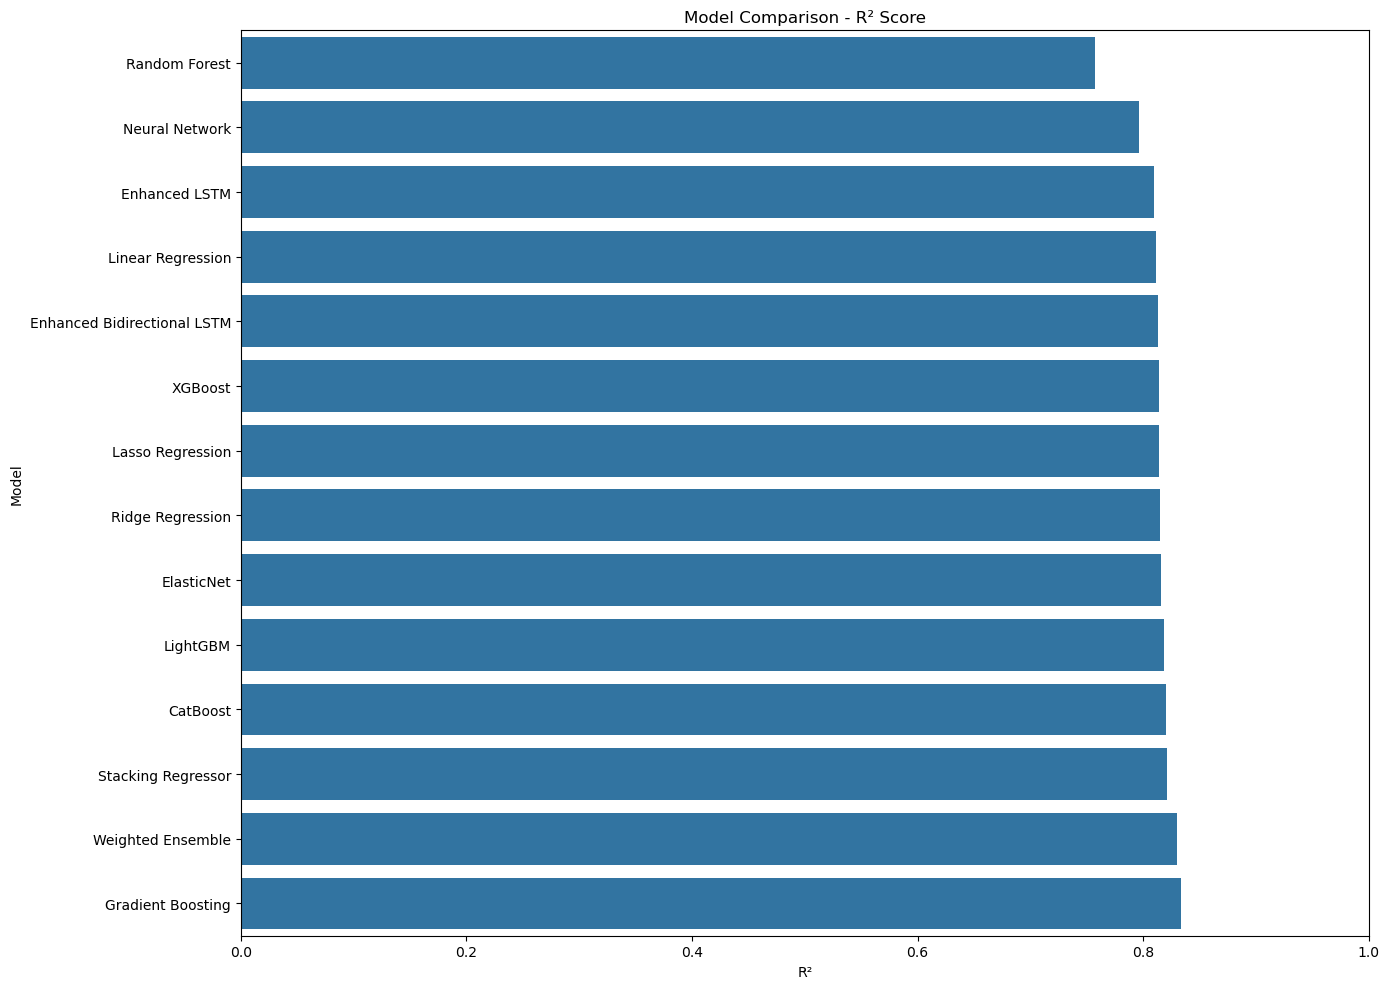

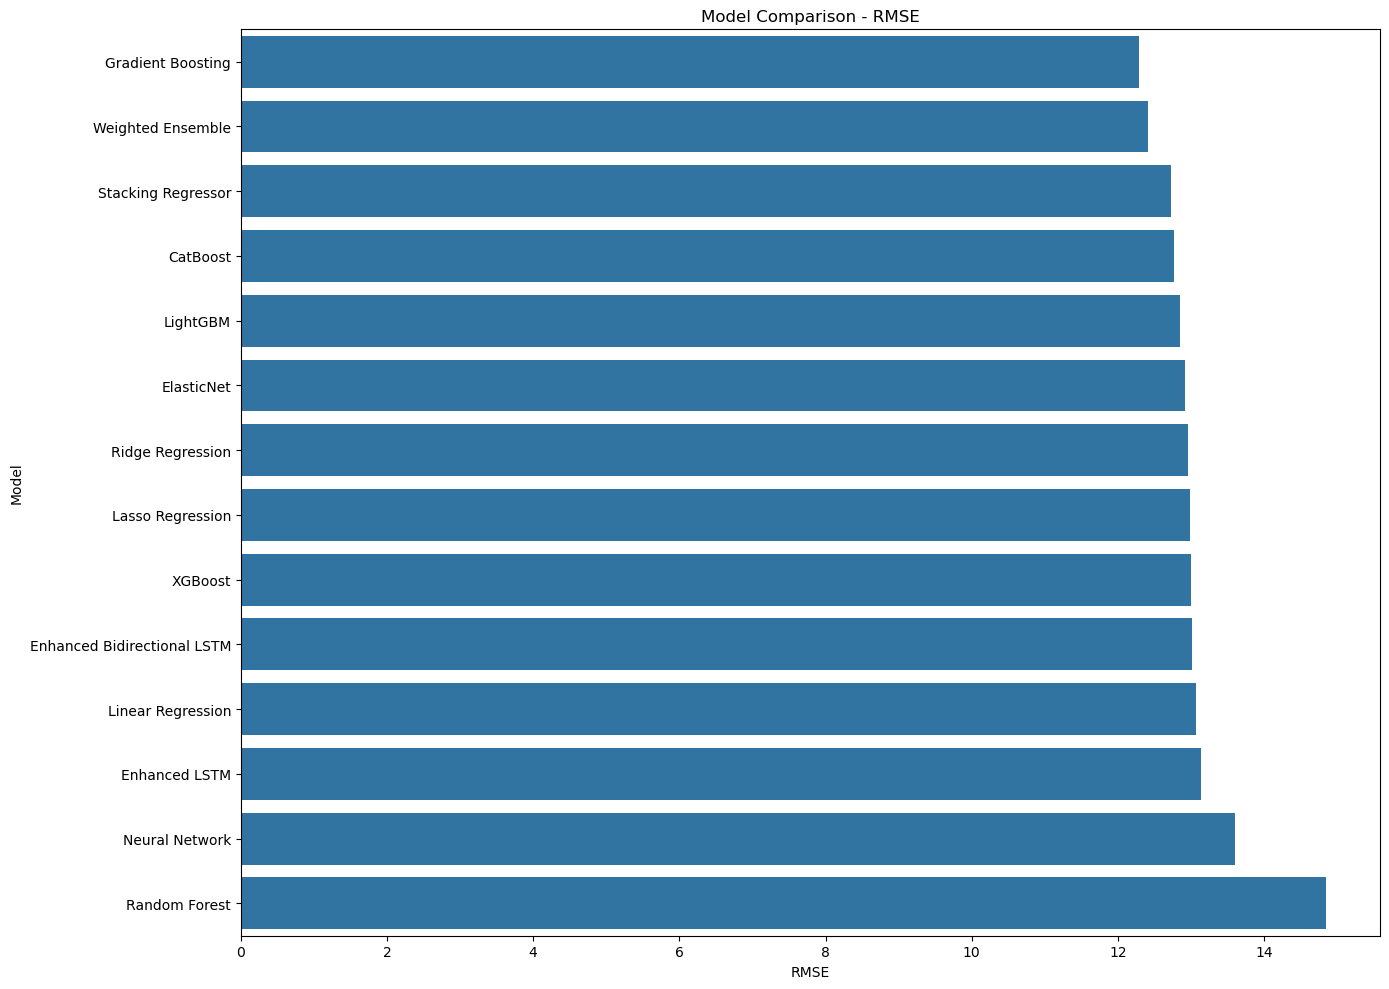

In [29]:
# Plot model comparison - R²
plt.figure(figsize=(14, 10))
sns.barplot(x='R²', y='Model', data=results_df.sort_values('R²'))
plt.title('Model Comparison - R² Score')
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig('model_results/model_comparison_r2.png')
plt.show()

# Plot model comparison - RMSE
plt.figure(figsize=(14, 10))
sns.barplot(x='RMSE', y='Model', data=results_df.sort_values('RMSE'))
plt.title('Model Comparison - RMSE')
plt.tight_layout()
plt.savefig('model_results/model_comparison_rmse.png')
plt.show()

In [30]:
# Plot actual vs predicted for best model
best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Model']
print(f"\nBest performing model: {best_model_name}")

# Get predictions from best model
if best_model_name == "Linear Regression":
    y_pred_best = y_pred_lr
elif best_model_name == "Ridge Regression":
    y_pred_best = y_pred_ridge
elif best_model_name == "Lasso Regression":
    y_pred_best = y_pred_lasso
elif best_model_name == "ElasticNet":
    y_pred_best = y_pred_elasticnet
elif best_model_name == "Random Forest":
    y_pred_best = y_pred_rf
elif best_model_name == "Gradient Boosting":
    y_pred_best = y_pred_gb
elif best_model_name == "XGBoost":
    y_pred_best = y_pred_xgb
elif best_model_name == "LightGBM":
    y_pred_best = y_pred_lgb
elif best_model_name == "CatBoost":
    y_pred_best = y_pred_cb
elif best_model_name == "Neural Network":
    y_pred_best = y_pred_nn
elif best_model_name == "LSTM":
    y_pred_best = y_pred_lstm
elif best_model_name == "Bidirectional LSTM":
    y_pred_best = y_pred_bilstm
elif best_model_name == "Voting Regressor":
    y_pred_best = y_pred_voting
elif best_model_name == "Stacking Regressor":
    y_pred_best = y_pred_stacking
elif best_model_name == "Weighted Ensemble":
    y_pred_best = y_pred_weighted
else:
    y_pred_best = y_pred_weighted


Best performing model: Gradient Boosting


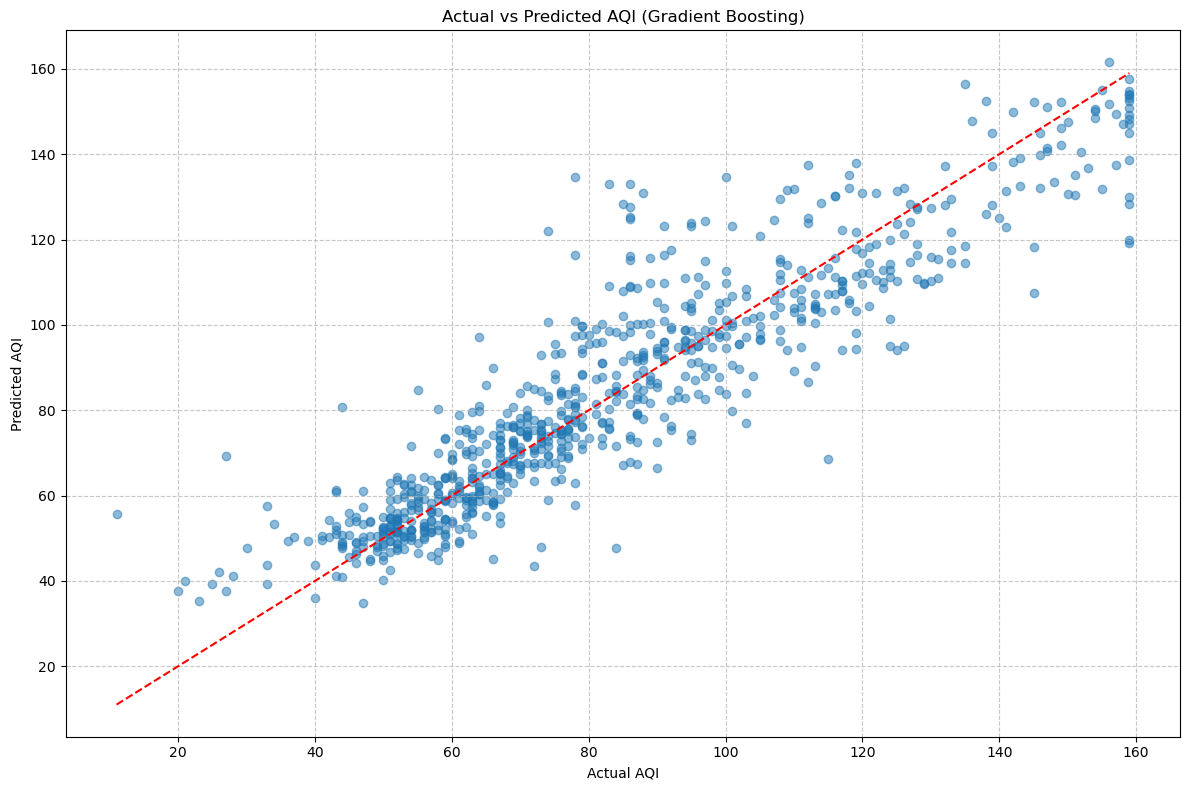

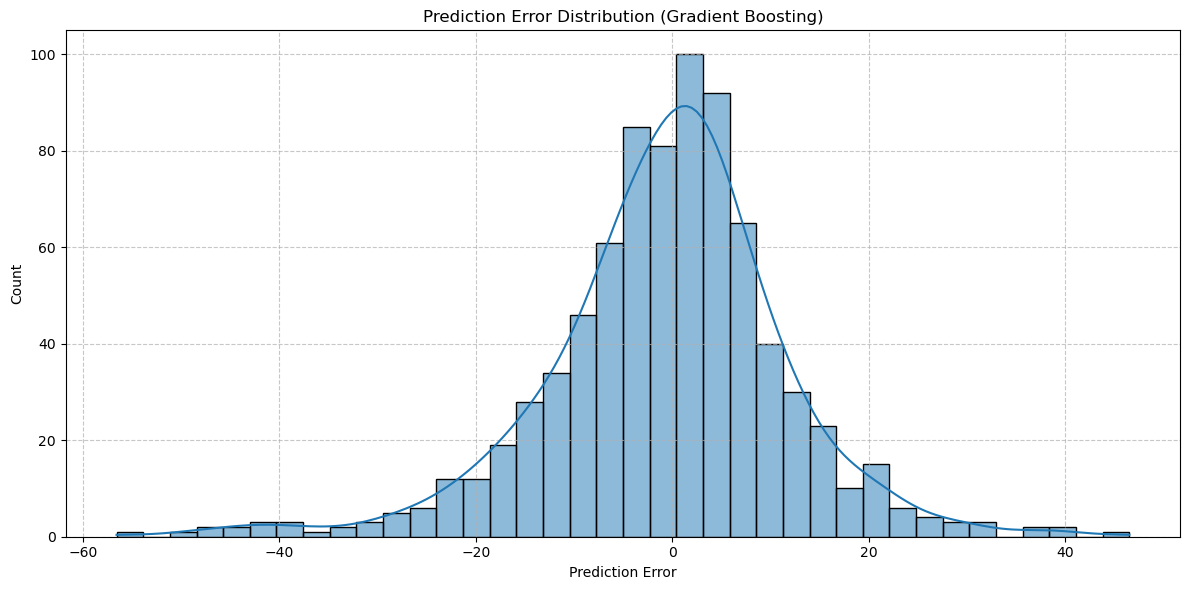

In [31]:
# Plot actual vs predicted
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title(f'Actual vs Predicted AQI ({best_model_name})')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_results/actual_vs_predicted.png')

# Plot prediction error distribution
error = y_test - y_pred_best
plt.figure(figsize=(12, 6))
sns.histplot(error, kde=True)
plt.title(f'Prediction Error Distribution ({best_model_name})')
plt.xlabel('Prediction Error')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_results/error_distribution.png')

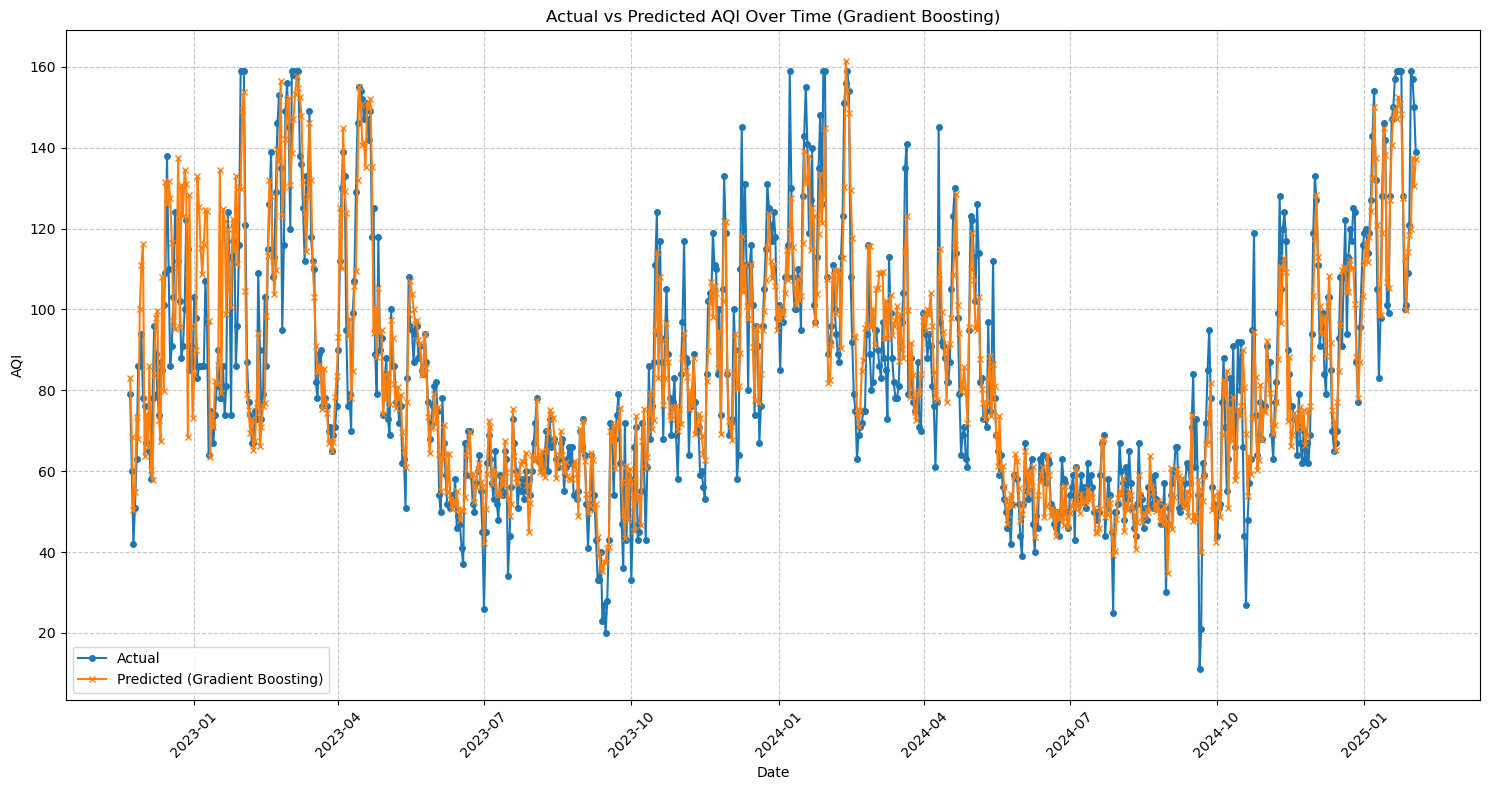

In [32]:
# Plot time series of actual vs predicted
plt.figure(figsize=(15, 8))
plt.plot(df['date'][split_idx:split_idx+len(y_test)], y_test, label='Actual', marker='o', markersize=4)
plt.plot(df['date'][split_idx:split_idx+len(y_test)], y_pred_best, label=f'Predicted ({best_model_name})', marker='x', markersize=4)
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title(f'Actual vs Predicted AQI Over Time ({best_model_name})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_results/time_series_prediction.png')

In [33]:
# ===============================
# 7. Future Data Prediction
# ===============================
print("\n--- Processing Future Data and Making Predictions ---")

# Create future data dictionary
future_dict = {
    'date': ["4/2/2025", "5/2/2025", "6/2/2025", "7/2/2025", "8/2/2025", "9/2/2025",
             "10/2/2025", "11/2/2025", "12/2/2025", "13/2/2025", "14/2/2025", "15/2/2025",
             "16/2/2025", "17/2/2025", "18/2/2025", "19/2/2025", "20/2/2025", "21/2/2025",
             "22/2/2025", "23/2/2025", "24/2/2025", "25/2/2025", "26/2/2025", "27/2/2025",
             "28/2/2025", "1/3/2025", "2/3/2025", "3/3/2025", "4/3/2025", "5/3/2025"],
    'pm25': [122, 134, 108, 118, 115, 86, 86, 126, 160, 153, 137, 130, 123, 94, 74, 91, 112, 126, 116, 106, 80, 84, 80, 100, 108, 85, 78, 81, 76, 67],
    'pm10': [63, 56, 58, 53, 44, 52, 62, 69, 63, 61, 59, 61, 53, 48, 48, 47, 49, 48, 43, 30, 39, 32, 40, 45, 42, 43, 42, 43, 45, 44],
    'o3': [19, 22, 23, 18, 19, 19, 21, 22, 26, 23, 23, 26, 21, 19, 16, 18, 15, 16, 16, 13, 9, 12, 15, 18, 19, 19, 17, 22, 20, 24],
    'no2': [1, 2, 1, np.nan, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, np.nan, np.nan, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1],
    'so2': [np.nan]*30,
    'co': [np.nan]*30,}


--- Processing Future Data and Making Predictions ---


In [37]:
future_data = pd.DataFrame(future_dict)

# Convert date to datetime
future_data['date'] = pd.to_datetime(future_data['date'], format='%d/%m/%Y', errors='coerce')

# Add missing one-hot encoded columns (set to 0)

# Fill missing no2 and so2 using the mean from historical data
no2_mean = df['no2'].mean()
so2_mean = df['so2'].mean()
future_data['no2'] = future_data['no2'].fillna(no2_mean)
future_data['so2'] = future_data['so2'].fillna(so2_mean)

# Add time-based features
future_data['year'] = future_data['date'].dt.year
future_data['month'] = future_data['date'].dt.month
future_data['day_of_year'] = future_data['date'].dt.dayofyear
future_data['day_of_week'] = future_data['date'].dt.dayofweek
future_data['is_weekend'] = future_data['day_of_week'].isin([5, 6]).astype(int)
future_data['season'] = pd.cut(future_data['month'], 
                              bins=[0, 3, 6, 9, 12], 
                              labels=['Winter', 'Spring', 'Summer', 'Fall'],
                              include_lowest=True)

# Add cyclical encoding
future_data['month_sin'] = np.sin(2 * np.pi * future_data['month']/12)
future_data['month_cos'] = np.cos(2 * np.pi * future_data['month']/12)
future_data['day_of_week_sin'] = np.sin(2 * np.pi * future_data['day_of_week']/7)
future_data['day_of_week_cos'] = np.cos(2 * np.pi * future_data['day_of_week']/7)
future_data['day_of_year_sin'] = np.sin(2 * np.pi * future_data['day_of_year']/365)
future_data['day_of_year_cos'] = np.cos(2 * np.pi * future_data['day_of_year']/365)

# Calculate AQI as max of pollutants
future_data['AQI'] = future_data[['pm25', 'pm10', 'o3', 'no2', 'so2']].max(axis=1)

# Create interaction terms
future_data['pm25_pm10_ratio'] = future_data['pm25'] / future_data['pm10'].replace(0, np.nan)
future_data['pm25_pm10_ratio'] = future_data['pm25_pm10_ratio'].fillna(df['pm25_pm10_ratio'].mean())

# Create lag features for the future data
# For the first day, use the last day from historical data
last_historical_data = df.iloc[-1]

# Initialize lag columns in future_data
for col in lag_columns:
    future_data[f'{col}_lag1'] = np.nan
    future_data[f'{col}_lag3'] = np.nan
    future_data[f'{col}_lag7'] = np.nan
    
    # Set first day's lag1 from historical data
    future_data.loc[0, f'{col}_lag1'] = last_historical_data[col]
    
    # For lag3 and lag7, use historical data if available
    if len(df) >= 3:
        future_data.loc[0, f'{col}_lag3'] = df.iloc[-3][col]
    else:
        future_data.loc[0, f'{col}_lag3'] = last_historical_data[col]
        
    if len(df) >= 7:
        future_data.loc[0, f'{col}_lag7'] = df.iloc[-7][col]
    else:
        future_data.loc[0, f'{col}_lag7'] = last_historical_data[col]

# Create rolling mean features
for col in ['pm25', 'pm10', 'o3', 'no2', 'so2']:
    # Initialize with NaN
    future_data[f'{col}_rolling3'] = np.nan
    future_data[f'{col}_rolling7'] = np.nan
    future_data[f'{col}_rolling14'] = np.nan
    future_data[f'{col}_rolling30'] = np.nan
    future_data[f'{col}_std7'] = np.nan
    future_data[f'{col}_std30'] = np.nan
    
    # Set first day's rolling means from historical data if available
    if len(df) >= 3:
        future_data.loc[0, f'{col}_rolling3'] = df[col].iloc[-3:].mean()
    else:
        future_data.loc[0, f'{col}_rolling3'] = df[col].mean()
        
    if len(df) >= 7:
        future_data.loc[0, f'{col}_rolling7'] = df[col].iloc[-7:].mean()
        future_data.loc[0, f'{col}_std7'] = df[col].iloc[-7:].std()
    else:
        future_data.loc[0, f'{col}_rolling7'] = df[col].mean()
        future_data.loc[0, f'{col}_std7'] = df[col].std()
        
    if len(df) >= 14:
        future_data.loc[0, f'{col}_rolling14'] = df[col].iloc[-14:].mean()
    else:
        future_data.loc[0, f'{col}_rolling14'] = df[col].mean()
        
    if len(df) >= 30:
        future_data.loc[0, f'{col}_rolling30'] = df[col].iloc[-30:].mean()
        future_data.loc[0, f'{col}_std30'] = df[col].iloc[-30:].std()
    else:
        future_data.loc[0, f'{col}_rolling30'] = df[col].mean()
        future_data.loc[0, f'{col}_std30'] = df[col].std()

# Fill in the lag values for the rest of the future days
for i in range(1, len(future_data)):
    # lag1 is previous day's value
    for col in lag_columns:
        # For lag1, always use the previous day's value
        future_data.loc[i, f'{col}_lag1'] = future_data.loc[i-1, col]
        
        # For lag3, we need to be careful with indices
        if i >= 3:  # If we have at least 3 days of future data
            future_data.loc[i, f'{col}_lag3'] = future_data.loc[i-3, col]
        elif i == 2:  # If we have 2 days of future data
            future_data.loc[i, f'{col}_lag3'] = future_data.loc[0, col]  # Use the first day
        elif i == 1:  # If we have 1 day of future data
            # Use historical data if available, otherwise use the first future day
            if len(df) >= 2:
                future_data.loc[i, f'{col}_lag3'] = df.iloc[-2][col]
            else:
                future_data.loc[i, f'{col}_lag3'] = future_data.loc[0, col]
        
        # For lag7, similar approach
        if i >= 7:  # If we have at least 7 days of future data
            future_data.loc[i, f'{col}_lag7'] = future_data.loc[i-7, col]
        elif i > 0:  # For days 1-6, use a mix of historical and available future data
            # Calculate how many days we need from historical data
            days_from_history = 7 - i
            if len(df) >= days_from_history:
                # If we have enough historical data, use it
                future_data.loc[i, f'{col}_lag7'] = df.iloc[-days_from_history][col]
            else:
                # Otherwise use the first future day
                future_data.loc[i, f'{col}_lag7'] = future_data.loc[0, col]
    
    # Calculate rolling means
    for col in ['pm25', 'pm10', 'o3', 'no2', 'so2']:
        # For rolling3
        if i >= 3:  # We have at least 3 days of data
            # Use the previous 3 days (not including current day)
            future_data.loc[i, f'{col}_rolling3'] = future_data.loc[i-3:i-1, col].mean()
        else:
            # For days 1-2, calculate manually using available data
            values = []
            # Add available future days
            for j in range(1, i+1):
                values.append(future_data.loc[i-j, col])
            
            # Add historical days if needed
            days_needed = 3 - len(values)
            for j in range(1, days_needed+1):
                if j <= len(df):
                    values.append(df.iloc[-j][col])
            
            future_data.loc[i, f'{col}_rolling3'] = np.mean(values) if values else np.nan
        
        # For rolling7
        if i >= 7:  # We have at least 7 days of data
            # Use the previous 7 days (not including current day)
            future_data.loc[i, f'{col}_rolling7'] = future_data.loc[i-7:i-1, col].mean()
            future_data.loc[i, f'{col}_std7'] = future_data.loc[i-7:i-1, col].std()
        else:
            # For days 1-6, calculate manually using available data
            values = []
            # Add available future days
            for j in range(1, i+1):
                values.append(future_data.loc[i-j, col])
            
            # Add historical days if needed
            days_needed = 7 - len(values)
            for j in range(1, days_needed+1):
                if j <= len(df):
                    values.append(df.iloc[-j][col])
            
            future_data.loc[i, f'{col}_rolling7'] = np.mean(values) if values else np.nan
            future_data.loc[i, f'{col}_std7'] = np.std(values) if len(values) > 1 else 0
        
        # For rolling14
        if i >= 14:  # We have at least 14 days of data
            future_data.loc[i, f'{col}_rolling14'] = future_data.loc[i-14:i-1, col].mean()
        else:
            values = []
            # Add available future days
            for j in range(1, i+1):
                values.append(future_data.loc[i-j, col])
            
            # Add historical days if needed
            days_needed = 14 - len(values)
            for j in range(1, days_needed+1):
                if j <= len(df):
                    values.append(df.iloc[-j][col])
            
            future_data.loc[i, f'{col}_rolling14'] = np.mean(values) if values else np.nan
        
        # For rolling30
        if i >= 30:  # We have at least 30 days of data
            future_data.loc[i, f'{col}_rolling30'] = future_data.loc[i-30:i-1, col].mean()
            future_data.loc[i, f'{col}_std30'] = future_data.loc[i-30:i-1, col].std()
        else:
            values = []
            # Add available future days
            for j in range(1, i+1):
                values.append(future_data.loc[i-j, col])
            
            # Add historical days if needed
            days_needed = 30 - len(values)
            for j in range(1, days_needed+1):
                if j <= len(df):
                    values.append(df.iloc[-j][col])
            
            future_data.loc[i, f'{col}_rolling30'] = np.mean(values) if values else np.nan
            future_data.loc[i, f'{col}_std30'] = np.std(values) if len(values) > 1 else 0

# Ensure all features needed for prediction are available
missing_features = [f for f in final_features if f not in future_data.columns]
if missing_features:
    print(f"Warning: Missing features in future data: {missing_features}")
    # Add missing features with default values
    for feature in missing_features:
        if feature in df.columns:
            future_data[feature] = df[feature].mean()
        else:
            future_data[feature] = 0  # Default value

# Select only the features needed for prediction
future_features = future_data[final_features]

# Fill any remaining NaN values with means from training data
for col in future_features.columns:
    if future_features[col].isnull().any():
        if col in X.columns:
            mean_val = X[col].mean()
        else:
            mean_val = 0
        future_features[col] = future_features[col].fillna(mean_val)
        print(f"Filled NaN values in {col} with mean: {mean_val:.4f}")

# Scale the features
future_features_scaled = scaler.transform(future_features)

# Make predictions with all models
future_predictions = {}

# Linear models
future_predictions['Linear Regression'] = lr.predict(future_features_scaled)
future_predictions['Ridge Regression'] = ridge_cv_grid.predict(future_features_scaled)
future_predictions['Lasso Regression'] = lasso_cv_grid.predict(future_features_scaled)
future_predictions['ElasticNet'] = elasticnet_cv_grid.predict(future_features_scaled)

# Tree-based models
future_predictions['Random Forest'] = rf_grid.predict(future_features_scaled)
future_predictions['Gradient Boosting'] = gb_grid.predict(future_features_scaled)
future_predictions['XGBoost'] = xgb_grid.predict(future_features_scaled)
future_predictions['LightGBM'] = lgb_grid.predict(future_features_scaled)
future_predictions['CatBoost'] = cb_model.predict(future_features_scaled)

# Neural Network models
future_predictions['Neural Network'] = nn_model.predict(future_features_scaled).flatten()
future_features_lstm = future_features_scaled.reshape(-1, 1, future_features_scaled.shape[1])
future_predictions['LSTM'] = lstm_model.predict(future_features_lstm).flatten()
future_predictions['Bidirectional LSTM'] = bilstm_model.predict(future_features_lstm).flatten()

# Ensemble models
future_predictions['Stacking Regressor'] = stacking_regressor.predict(future_features_scaled)

# Weighted Ensemble prediction
future_predictions['Weighted Ensemble'] = np.zeros(len(future_features))
for i, model_name in enumerate(top_model_names):
    if model_name in future_predictions:
        future_predictions['Weighted Ensemble'] += weights[i] * future_predictions[model_name]

# Add predictions to future_data
for model_name, predictions in future_predictions.items():
    future_data[f'AQI_pred_{model_name.replace(" ", "_")}'] = predictions

# Create a result table with the best models
best_models = results_df.sort_values('R²', ascending=False).head(5)['Model'].tolist()
result_columns = ['date', 'AQI'] + [f'AQI_pred_{model.replace(" ", "_")}' for model in best_models]
result_table = future_data[result_columns]
result_table.columns = ['Date', 'Actual AQI'] + best_models

print("\nFuture AQI Prediction Results:")
print(result_table.head())

# Save predictions to CSV
result_table.to_csv('model_results/future_predictions.csv', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Future AQI Prediction Results:
        Date  Actual AQI  Gradient Boosting  Weighted Ensemble  \
0 2025-02-04       122.0         114.555864         121.658577   
1 2025-02-05       134.0         120.860440         121.111245   
2 2025-02-06       108.0         112.354614         114.072841   
3 2025-02-07       118.0         108.167222         111.928980   
4 2025-02-08       115.0          96.254312          97.440052   

   Stacking Regressor    CatBoost    LightGBM  
0          122.789020  120.280227  126.421563  
1          127.466633  110.398641  124.253394  
2          117.918301  107.630724  115.956413  
3          116.227103  103.119731  111.438929  
4          100.459274   90.522746   96.538306  


In [38]:
# Add predictions to future_data
for model_name, predictions in future_predictions.items():
    future_data[f'AQI_pred_{model_name.replace(" ", "_")}'] = predictions

# Create a result table with predictions from all models
all_model_names = list(future_predictions.keys())
result_columns = ['date', 'AQI'] + [f'AQI_pred_{model.replace(" ", "_")}' for model in all_model_names]
result_table = future_data[result_columns]
result_table.columns = ['Date', 'Actual AQI'] + all_model_names

print("\nFuture AQI Prediction Results (All Models):")
print(result_table)

# Save predictions to CSV
result_table.to_csv('model_results/future_predictions.csv', index=False)



Future AQI Prediction Results (All Models):
         Date  Actual AQI  Linear Regression  Ridge Regression  \
0  2025-02-04       122.0         123.879415        124.370285   
1  2025-02-05       134.0         123.411000        123.079543   
2  2025-02-06       108.0         116.970081        116.903484   
3  2025-02-07       118.0         121.407417        121.239405   
4  2025-02-08       115.0         103.594153        103.644612   
5  2025-02-09        86.0         105.497111        105.471297   
6  2025-02-10        86.0         114.811866        114.505936   
7  2025-02-11       126.0         134.847507        133.847836   
8  2025-02-12       160.0         137.625336        137.018287   
9  2025-02-13       153.0         134.801897        134.259602   
10 2025-02-14       137.0         128.465343        128.191101   
11 2025-02-15       130.0         130.308550        129.925496   
12 2025-02-16       123.0         114.773596        114.795926   
13 2025-02-17        94.0      

In [39]:
# Add predictions to future_data
for model_name, predictions in future_predictions.items():
    future_data[f'AQI_pred_{model_name.replace(" ", "_")}'] = predictions

# Create a result table with predictions from all models
all_model_names = list(future_predictions.keys())
result_columns = ['date', 'AQI'] + [f'AQI_pred_{model.replace(" ", "_")}' for model in all_model_names]
result_table = future_data[result_columns]
result_table.columns = ['Date', 'Actual AQI'] + all_model_names

# Calculate the difference between actual and predicted values for each model
for model in all_model_names:
    diff_col_name = f'Diff_{model.replace(" ", "_")}'
    result_table[diff_col_name] = result_table['Actual AQI'] - result_table[model]
    # To compute absolute difference instead, use:
    # result_table[diff_col_name] = (result_table['Actual AQI'] - result_table[model]).abs()

print("\nFuture AQI Prediction Results (All Models) with Differences:")
print(result_table)

# Save the results to CSV (including difference columns)
result_table.to_csv('model_results/future_predictions_with_diff.csv', index=False)



Future AQI Prediction Results (All Models) with Differences:
         Date  Actual AQI  Linear Regression  Ridge Regression  \
0  2025-02-04       122.0         123.879415        124.370285   
1  2025-02-05       134.0         123.411000        123.079543   
2  2025-02-06       108.0         116.970081        116.903484   
3  2025-02-07       118.0         121.407417        121.239405   
4  2025-02-08       115.0         103.594153        103.644612   
5  2025-02-09        86.0         105.497111        105.471297   
6  2025-02-10        86.0         114.811866        114.505936   
7  2025-02-11       126.0         134.847507        133.847836   
8  2025-02-12       160.0         137.625336        137.018287   
9  2025-02-13       153.0         134.801897        134.259602   
10 2025-02-14       137.0         128.465343        128.191101   
11 2025-02-15       130.0         130.308550        129.925496   
12 2025-02-16       123.0         114.773596        114.795926   
13 2025-02-17 


Model building, evaluation, and future predictions completed successfully.
Results and visualizations saved to 'model_results' directory.


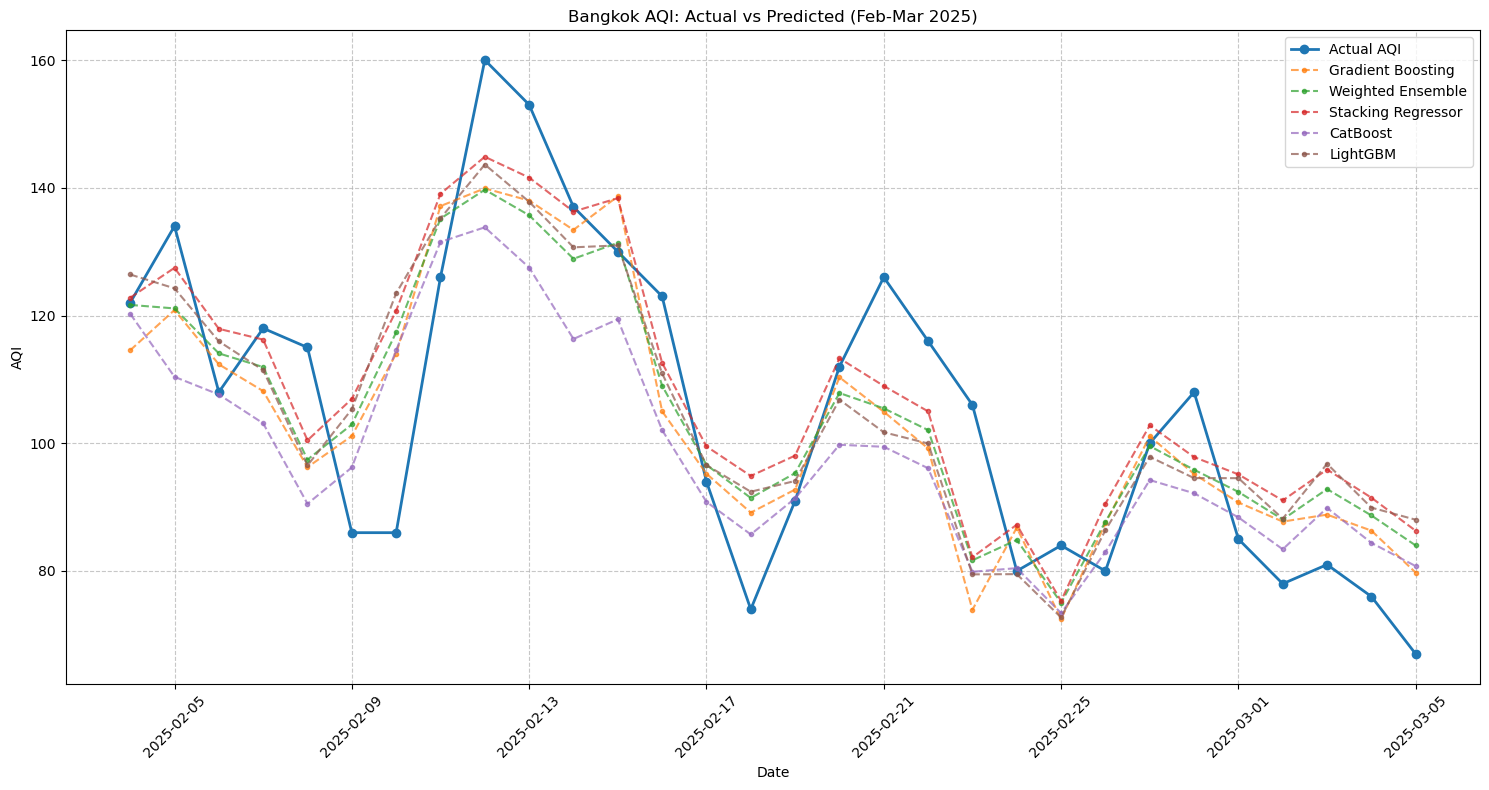

In [40]:
# Plot future predictions
plt.figure(figsize=(15, 8))
plt.plot(future_data['date'], future_data['AQI'], marker='o', linestyle='-', linewidth=2, label='Actual AQI')

# Plot predictions from best models
for model in best_models:
    plt.plot(future_data['date'], future_data[f'AQI_pred_{model.replace(" ", "_")}'], 
             marker='.', linestyle='--', alpha=0.7, label=f'{model}')

plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Bangkok AQI: Actual vs Predicted (Feb-Mar 2025)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_results/future_predictions.png')

print("\nModel building, evaluation, and future predictions completed successfully.")
print("Results and visualizations saved to 'model_results' directory.")


Model building, evaluation, and future predictions completed successfully.
Results and visualizations saved to 'model_results' directory.


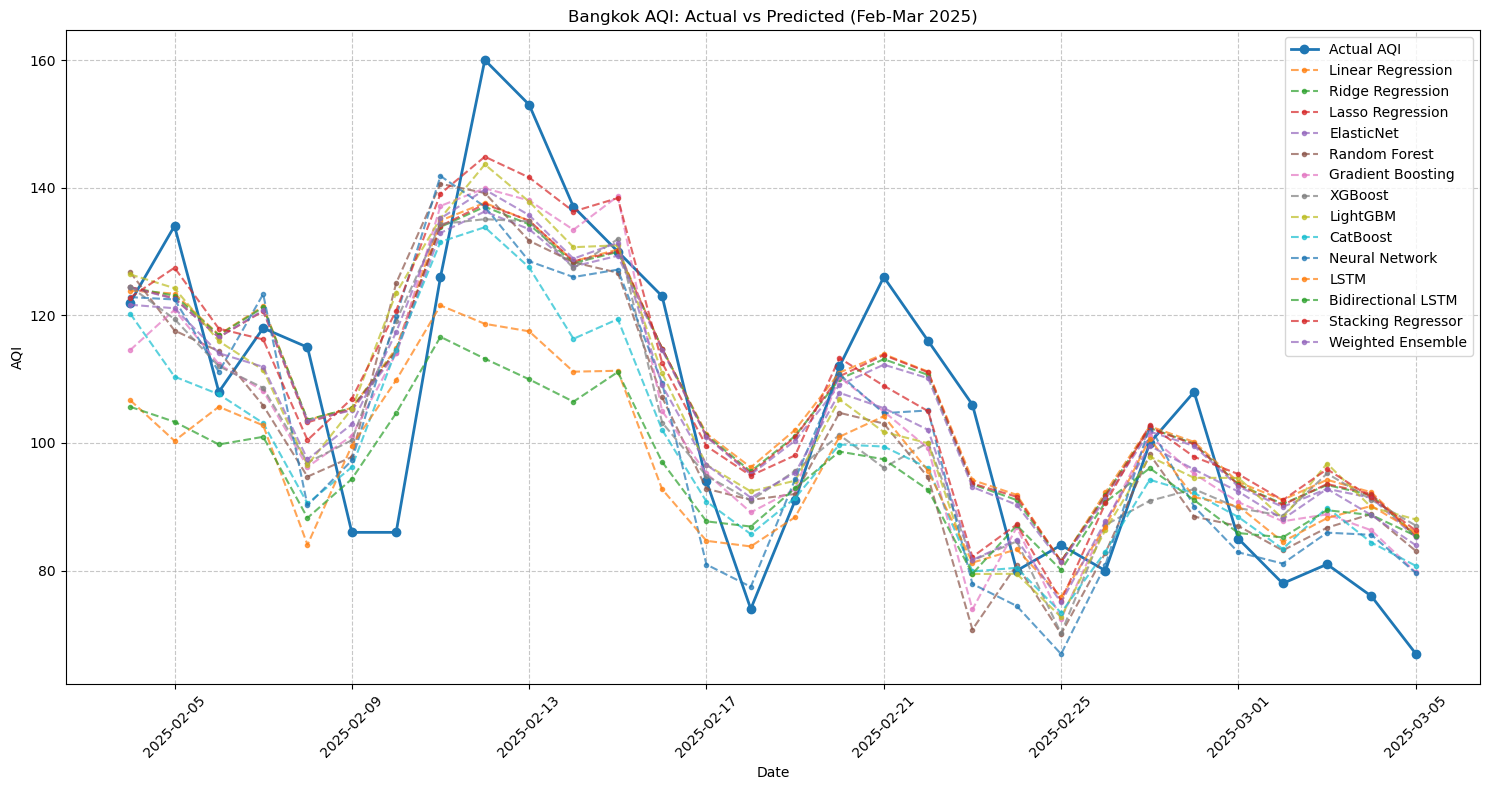

In [41]:
# Plot future predictions
plt.figure(figsize=(15, 8))
plt.plot(future_data['date'], future_data['AQI'], marker='o', linestyle='-', linewidth=2, label='Actual AQI')

# Retrieve all model names from the future_predictions dictionary
all_model_names = list(future_predictions.keys())

# Plot predictions from all models
for model in all_model_names:
    plt.plot(future_data['date'], future_data[f'AQI_pred_{model.replace(" ", "_")}'], 
             marker='.', linestyle='--', alpha=0.7, label=model)

plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Bangkok AQI: Actual vs Predicted (Feb-Mar 2025)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_results/future_predictions.png')

print("\nModel building, evaluation, and future predictions completed successfully.")
print("Results and visualizations saved to 'model_results' directory.")
